<a href="https://colab.research.google.com/github/PROACT-team/2023-Loss-of-autonomy-in-swallowing/blob/main/7_Supplementary_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparation

In [ ]:
pip install pyreadr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr

In [ ]:
# adjusting figure resolution
plt.rcParams['figure.dpi'] = 300

In [ ]:
pip install scikit-learn==1.2.2

In [ ]:
pip install scikit-survival==0.20.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 28.1 MB/s eta 0:00:00


In [ ]:
pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 11.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=22644be5dabd486d5d94b31eead7883484bc0a0b3f07d626a45682b5daf39335
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
from sksurv.ensemble import RandomSurvivalForest

In [ ]:
from lifelines import KaplanMeierFitter

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
# Read datasets needed (if using google drive
X_with_nans_snuh = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Files/X_and_Y_SNUH_with_NaNs.csv')
proact_train_set = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Files/X_and_Y_with_NaNs.csv')
study_population = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Files/PRO-ACT_filtered.csv')
snuh_frs1 = pd.read_excel('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/20170420_20191030_ALSFRS.xlsx', engine='openpyxl')
snuh_frs2 = pd.read_excel('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/20170612_20210726_ALSFRS.xlsx', engine='openpyxl')

<ipython-input-11-16f7613383c6>:4: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  study_population = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Files/PRO-ACT_filtered.csv')


In [ ]:
base = pyreadr.read_r('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/base.rds')[None].drop(columns=['Name'])
dx = pyreadr.read_r('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/dx.rds')[None]

In [ ]:
X_with_nans_snuh.drop(['Unnamed: 0'], axis = 1, inplace=True)
proact_train_set.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [ ]:
# Final feature list
aft_final_feature_list = ['onset_site', 'Age', 'mean_R3_Respiratory_Insufficiency', 'slope_ALSFRS_R_Total',
                          'mean_Q7_Turning_in_Bed', 'mean_Q2_Salivation', 'slope_Q2_Salivation',
                          'slope_R3_Respiratory_Insufficiency', 'slope_Q8_Walking', 'slope_Q1_Speech',
                          'mean_Q3_Swallowing', 'slope_Q6_Dressing_and_Hygiene', 'mean_bulbar']

cph_final_feature_list = ['mean_bulbar', 'slope_Q6_Dressing_and_Hygiene', 'mean_Q3_Swallowing', 'slope_Q1_Speech',
                          'slope_Q2_Salivation', 'slope_Q8_Walking', 'mean_Q2_Salivation', 'slope_ALSFRS_R_Total',
                          'mean_Q7_Turning_in_Bed', 'mean_R3_Respiratory_Insufficiency', 'Age', 'onset_site']

rsf_final_feature_list = ['slope_ALSFRS_R_Total', 'mean_weight', 'diag_delta', 'Age', 'onset_site', 'mean_fvc',
                          'mean_Q3_Swallowing', 'mean_ALSFRS_R_Total', 'mean_Q2_Salivation', 'onset_delta',
                          'mean_Q1_Speech', 'mean_bulbar']

In [ ]:
#missing data imputation - PRO-ACT data
all_features_list = list (set(proact_train_set.columns)-set(['SubjectID', 'time_LOA', 'status_LOA']))


proact_train_set_imputed = proact_train_set.copy()
imputer = IterativeImputer(max_iter=10, random_state=11)
imputer.fit(proact_train_set[all_features_list])
proact_train_set_imputed[all_features_list] = imputer.transform(proact_train_set[all_features_list])

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
#missing data imputation - SNUH data
snuh_all_features = list (set(X_with_nans_snuh.columns)-set(['SubjectID', 'time_LOA', 'status_LOA', 'slope_fvc']))
X_with_nans_snuh2 = X_with_nans_snuh.copy()
snuh_imputed = X_with_nans_snuh2.copy() #Because SNUH data has every 'slope_fvc' value missing, the column was removed to prevent imputation error
imputer = IterativeImputer(max_iter=10, random_state=12)
imputer.fit(X_with_nans_snuh2[snuh_all_features])
snuh_imputed[snuh_all_features] = imputer.transform(X_with_nans_snuh2[snuh_all_features])

In [ ]:
# import final models
df_train = proact_train_set_imputed.copy()
# Random Survival Forests requires array-type data, thus additional preprocessing was needed
dic = {1:True, 0:False}

df_train_rsf = df_train[['status_LOA', 'time_LOA']]
df_train_rsf = df_train_rsf.replace({'status_LOA':dic})
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt = np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']
y_train_rsf

array([(False, 10.18), ( True,  6.44), (False,  2.06), ...,
       (False,  9.82), (False,  3.05), (False,  1.14)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
# Bring the final AFT model
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer = 0.01, l1_ratio = 1)
aft.fit(df_train[aft_final_feature_list+['time_LOA', 'status_LOA']], duration_col='time_LOA', event_col='status_LOA', ancillary=False)

<lifelines.WeibullAFTFitter: fitted with 2670 total observations, 2093 right-censored observations>

In [ ]:
# Bring the final COX model
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01, l1_ratio = 1)
cph.fit(df_train[cph_final_feature_list+['time_LOA', 'status_LOA']], 'time_LOA', event_col='status_LOA')

<lifelines.CoxPHFitter: fitted with 2670 total observations, 2093 right-censored observations>

In [ ]:
# Bring the final RSF model
# CAUTION! Runtime takes 1 min
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=8,  min_samples_leaf=10, max_features="auto",
                           n_jobs=-1, random_state=20)
rsf.fit(df_train[rsf_final_feature_list], y_train_rsf)

RandomSurvivalForest(max_features='auto', min_samples_leaf=10,
                     min_samples_split=8, n_jobs=-1, random_state=20)

#1-1. Visualization (group)

## AFT

### (1) Categorizing patient data

In [ ]:
aft_median = pd.concat([df_train['SubjectID'],aft.predict_percentile(df_train[aft_final_feature_list], ancillary=None, p=0.5)], axis=1)
aft_median

,SubjectID,0
0,348.0,46.618678
1,533.0,4.400536
2,902.0,18.014172
3,1736.0,8.302051
4,3971.0,39.404477
...,...,...
2665,996981.0,41.096885
2666,997829.0,12.181359
2667,999166.0,20.715588
2668,999823.0,17.204249


In [ ]:
print('There are ' + str(aft_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in aft_median')

There are 0 inf values in aft_median


In [ ]:
aft_median[0].describe()

count    2670.000000
mean       30.023966
std        16.089970
min         1.467013
25%        16.640332
50%        29.160084
75%        41.466405
max       104.016441
Name: 0, dtype: float64

In [ ]:
aft_slow_list = list(aft_median[aft_median[0] >= 	41.466405]['SubjectID'])
aft_intermediate_list = list(aft_median[(aft_median[0] >= 16.640332) & (aft_median[0] < 	41.466405)]['SubjectID'])
aft_rapid_list = list(aft_median[aft_median[0]  < 16.640332]['SubjectID'])
X_aft_slow = df_train[df_train['SubjectID'].isin(aft_slow_list)]
X_aft_intermediate = df_train[df_train['SubjectID'].isin(aft_intermediate_list)]
X_aft_rapid = df_train[df_train['SubjectID'].isin(aft_rapid_list)]

In [ ]:
result_aft_slow = pd.DataFrame(aft.predict_survival_function(X_aft_slow[aft_final_feature_list].iloc[:,:]).mean(axis=1))
result_aft_intermediate = pd.DataFrame(aft.predict_survival_function(X_aft_intermediate[aft_final_feature_list].iloc[:,:]).mean(axis=1))
result_aft_rapid = pd.DataFrame(aft.predict_survival_function(X_aft_rapid[aft_final_feature_list].iloc[:,:]).mean(axis=1))

### (2) Plot

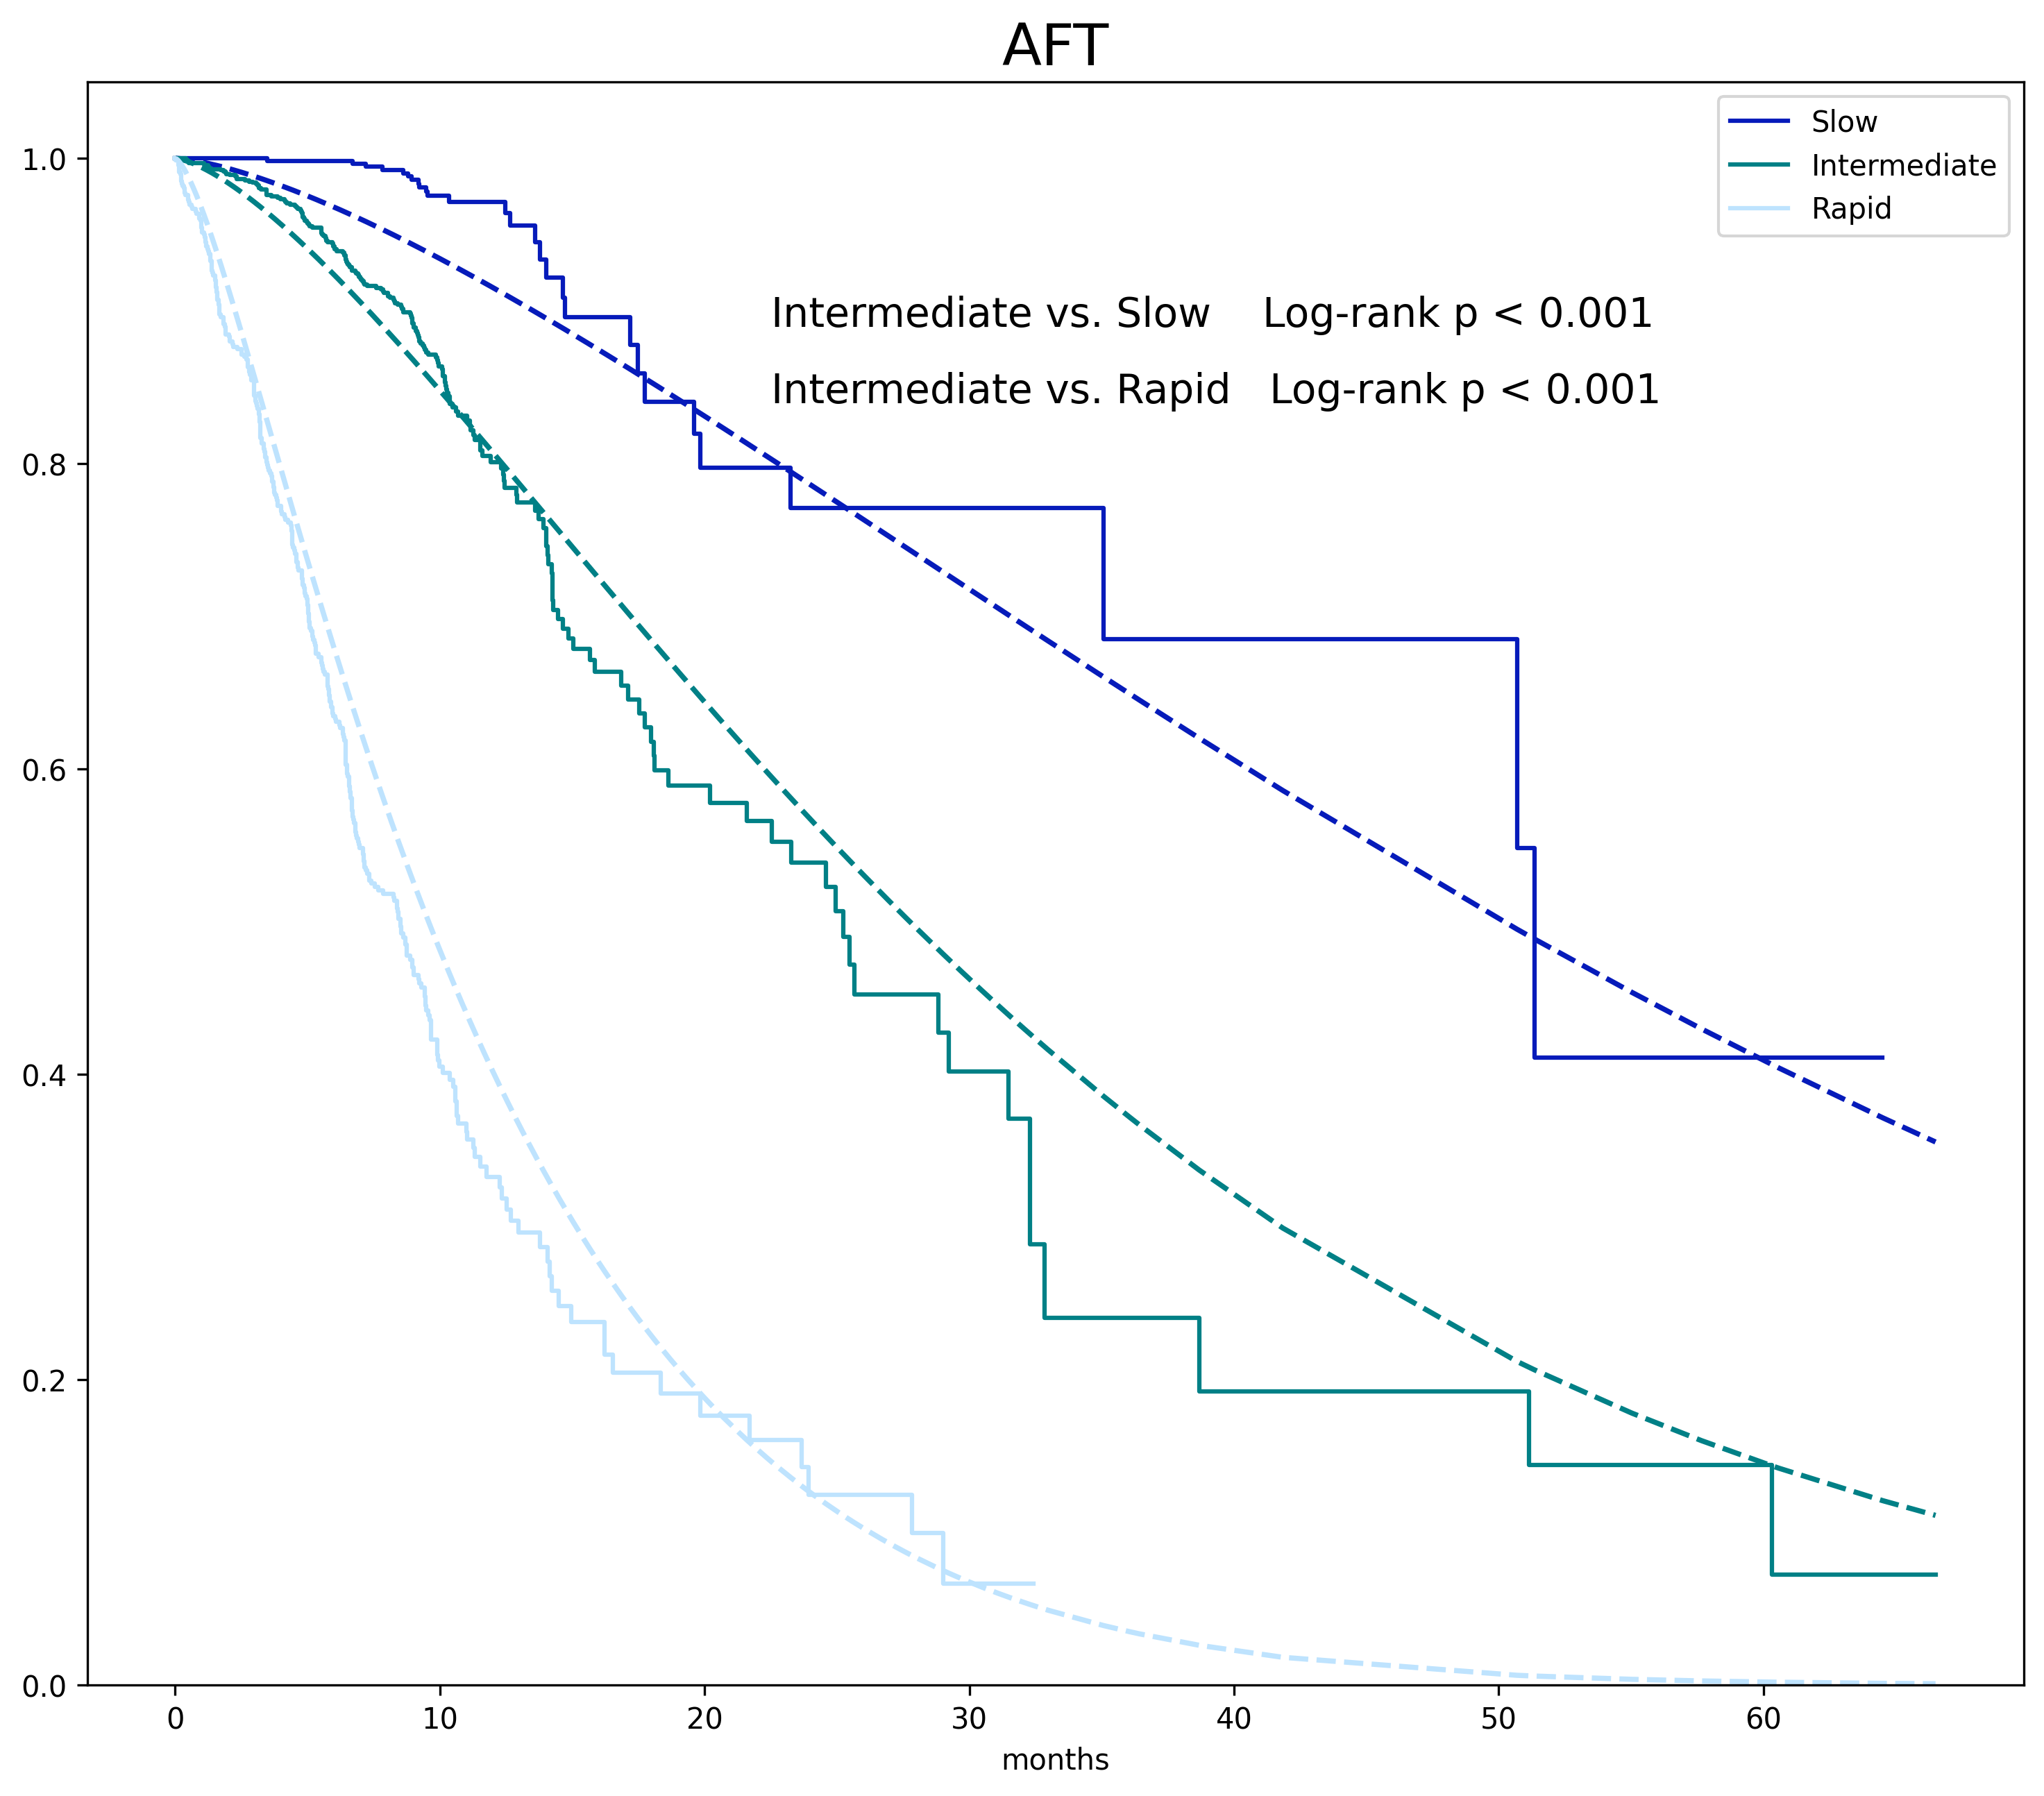

In [ ]:
from lifelines import KaplanMeierFitter
from scipy.stats import ranksums

kmf = KaplanMeierFitter()

plt.figure(figsize=(12,10))

OPT = kmf.fit(X_aft_slow["time_LOA"], X_aft_slow["status_LOA"], label='Slow', alpha=1)
ax_kmf = OPT.plot(color='#061BBA', linewidth=1.5)
plt.plot(result_aft_slow.index, result_aft_slow[0], marker='None', color='#061BBA', linestyle="--", linewidth=1.8)


OPT = kmf.fit(X_aft_intermediate["time_LOA"], X_aft_intermediate["status_LOA"], label='Intermediate', alpha=1)
ax_kmf = OPT.plot(color='#008086', linewidth=1.5)
plt.title("Intermediate")
plt.plot(result_aft_intermediate.index, result_aft_intermediate[0], marker='None', color='#008086', linestyle="--", linewidth=1.8)

OPT = kmf.fit(X_aft_rapid["time_LOA"], X_aft_rapid["status_LOA"], label='Rapid', alpha=1)
ax_kmf = OPT.plot(color='#BEE3FE', linewidth=1.5)
plt.plot(result_aft_rapid.index, result_aft_rapid[0], marker='None', color='#BEE3FE', linestyle="--", linewidth=1.8)
plt.ylim([0,1.05])

plt.xlabel('months')
plt.title('AFT', fontsize=20)

# Calculate log-rank test p-value
log_rank_result_si = logrank_test(X_aft_slow["time_LOA"], X_aft_intermediate["time_LOA"], X_aft_slow["status_LOA"], X_aft_intermediate["status_LOA"])
log_rank_result_ir = logrank_test(X_aft_intermediate["time_LOA"], X_aft_rapid["time_LOA"], X_aft_intermediate["status_LOA"], X_aft_rapid["status_LOA"])

# Format the p-values as "p < 0.001" if they are less than 0.001
formatted_p_value_si = f'p < 0.001' if log_rank_result_si.p_value < 0.001 else f'p = {log_rank_result_si.p_value:.4f}'
formatted_p_value_ir = f'p < 0.001' if log_rank_result_ir.p_value < 0.001 else f'p = {log_rank_result_ir.p_value:.4f}'

# Add the p-values as annotations to the plots
plt.annotate(f'Intermediate vs. Slow    Log-rank {formatted_p_value_si}', xy=(22.5,0.89), color='k', fontsize=14)
plt.annotate(f'Intermediate vs. Rapid   Log-rank {formatted_p_value_ir}', xy=(22.5,0.84), color='k', fontsize=14)

plt.show()

## COX

### (1) Categorizing patient data

In [ ]:
cph_median = pd.concat([df_train['SubjectID'],cph.predict_percentile(df_train[cph_final_feature_list], p=0.5)], axis=1)
cph_median

,SubjectID,0.5
0,348.0,51.15
1,533.0,4.79
2,902.0,17.52
3,1736.0,9.00
4,3971.0,38.69
...,...,...
2665,996981.0,38.69
2666,997829.0,11.53
2667,999166.0,19.85
2668,999823.0,14.85


In [ ]:
print('There are ' + str(cph_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in cph_median')

There are 78 inf values in cph_median


In [ ]:
cph_infinity = list(cph_median[cph_median[0.5]==np.inf]['SubjectID'])

In [ ]:
function = pd.concat([df_train['SubjectID'],aft.predict_survival_function(df_train[aft_final_feature_list]).transpose()], axis=1)
last_point= function.iloc[:, [0,-1]]
last_point[0.5] = (0.5*last_point.columns[1])/(1-last_point.iloc[:,1])
cph_median_inf = last_point[last_point['SubjectID'].isin(cph_infinity)][['SubjectID',0.5]]
cph_median_inf

<ipython-input-78-fb7fd2178c58>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_point[0.5] = (0.5*last_point.columns[1])/(1-last_point.iloc[:,1])


,SubjectID,0.5
180,59405.0,86.708793
213,68949.0,63.186497
219,71698.0,63.402297
227,76092.0,76.813286
265,93998.0,63.898117
...,...,...
2460,927649.0,66.789935
2547,958493.0,63.741121
2553,959911.0,77.814718
2556,960182.0,66.985361


In [ ]:
cph_median = pd.concat([cph_median[cph_median[0.5]!=np.inf],cph_median_inf], axis=0)
cph_median

,SubjectID,0.5
0,348.0,51.150000
1,533.0,4.790000
2,902.0,17.520000
3,1736.0,9.000000
4,3971.0,38.690000
...,...,...
2460,927649.0,66.789935
2547,958493.0,63.741121
2553,959911.0,77.814718
2556,960182.0,66.985361


In [ ]:
print('There are ' + str(cph_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in cph_median after extension')

There are 0 inf values in cph_median after extension


In [ ]:
cph_median[0.5].describe()

count    2670.000000
mean       30.579821
std        17.048225
min         1.370000
25%        14.850000
50%        31.490000
75%        38.690000
max       109.316554
Name: 0.5, dtype: float64

In [ ]:
cph_slow_list = list(cph_median[cph_median[0.5] >= 	38.690000]['SubjectID'])
cph_intermediate_list = list(cph_median[(cph_median[0.5] >=  14.850000) & (cph_median[0.5] < 	38.690000)]['SubjectID'])
cph_rapid_list = list(cph_median[cph_median[0.5]  <  14.850000]['SubjectID'])
X_cph_slow = df_train[df_train['SubjectID'].isin(cph_slow_list)]
X_cph_intermediate = df_train[df_train['SubjectID'].isin(cph_intermediate_list)]
X_cph_rapid = df_train[df_train['SubjectID'].isin(cph_rapid_list)]

In [ ]:
result_cph_slow = pd.DataFrame(cph.predict_survival_function(X_cph_slow[cph_final_feature_list].iloc[:,:]).mean(axis=1))
result_cph_intermediate = pd.DataFrame(cph.predict_survival_function(X_cph_intermediate[cph_final_feature_list].iloc[:,:]).mean(axis=1))
result_cph_rapid = pd.DataFrame(cph.predict_survival_function(X_cph_rapid[cph_final_feature_list].iloc[:,:]).mean(axis=1))

### (2) Plot

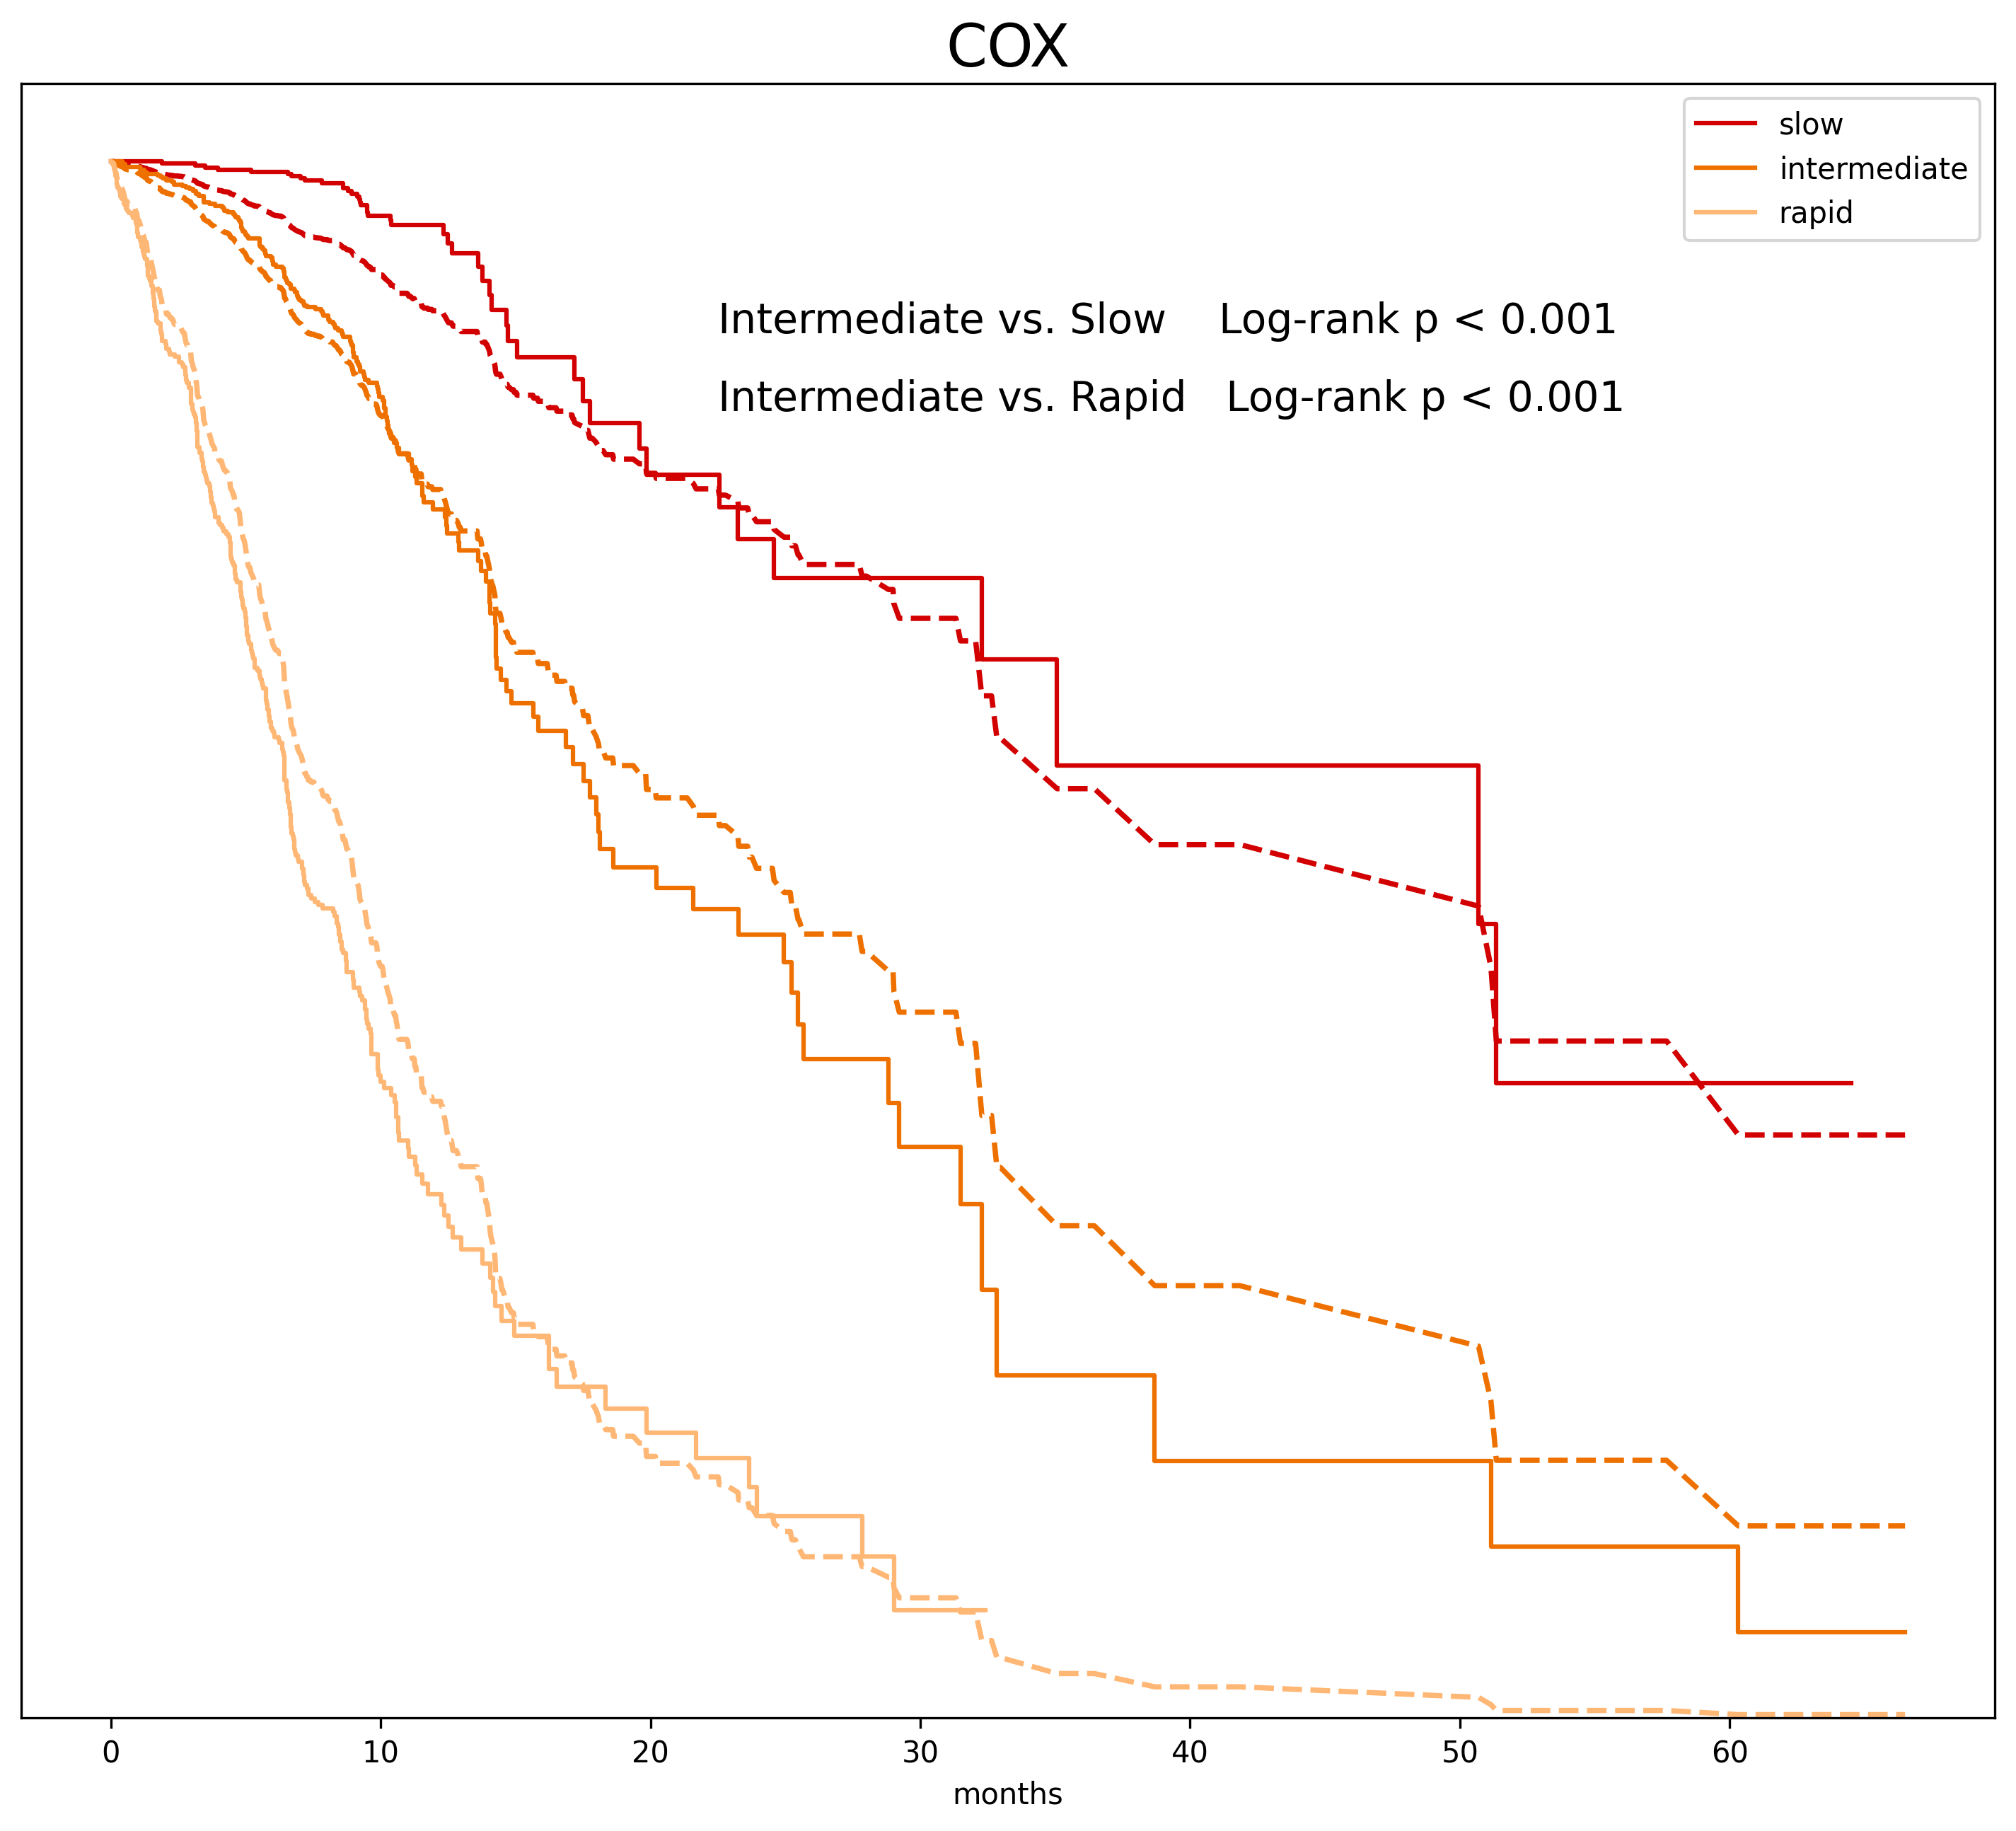

In [ ]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(12,10))

OPT = kmf.fit(X_cph_slow["time_LOA"], X_cph_slow["status_LOA"], label='slow', alpha=1)
ax_kmf = OPT.plot(color='#D20000', linewidth=1.5)
plt.plot(result_cph_slow.index, result_cph_slow[0], marker='None', color='#D20000', linestyle="--", linewidth=1.8)


OPT = kmf.fit(X_cph_intermediate["time_LOA"], X_cph_intermediate["status_LOA"], label='intermediate', alpha=1)
ax_kmf = OPT.plot(color='#EE7100', linewidth=1.5)
plt.title("Intermediate")
plt.plot(result_cph_intermediate.index, result_cph_intermediate[0], marker='None', color='#EE7100', linestyle="--", linewidth=1.8)

OPT = kmf.fit(X_cph_rapid["time_LOA"], X_cph_rapid["status_LOA"], label='rapid', alpha=1)
ax_kmf = OPT.plot(color='#FFB775', linewidth=1.5)
plt.plot(result_cph_rapid.index, result_cph_rapid[0], marker='None', color='#FFB775', linestyle="--", linewidth=1.8)

# Calculate log-rank test p-value
log_rank_result_si = logrank_test(X_cph_slow["time_LOA"], X_cph_intermediate["time_LOA"], X_cph_slow["status_LOA"], X_cph_intermediate["status_LOA"])
log_rank_result_ir = logrank_test(X_cph_intermediate["time_LOA"], X_cph_rapid["time_LOA"], X_cph_intermediate["status_LOA"], X_cph_rapid["status_LOA"])

# Format the p-values as "p < 0.001" if they are less than 0.001
formatted_p_value_si = f'p < 0.001' if log_rank_result_si.p_value < 0.001 else f'p = {log_rank_result_si.p_value:.4f}'
formatted_p_value_ir = f'p < 0.001' if log_rank_result_ir.p_value < 0.001 else f'p = {log_rank_result_ir.p_value:.4f}'

# Add the p-values as annotations to the plots
plt.annotate(f'Intermediate vs. Slow    Log-rank {formatted_p_value_si}', xy=(22.5,0.89), color='k', fontsize=14)
plt.annotate(f'Intermediate vs. Rapid   Log-rank {formatted_p_value_ir}', xy=(22.5,0.84), color='k', fontsize=14)

plt.ylim([0,1.05])
plt.yticks([])
plt.xlabel('months')
plt.title('COX', fontsize=20)

plt.show()

## RSF

### (1) Categorizing patient data

In [ ]:
def predict_rsf_percentile(data, percentile):
  result = rsf.predict_survival_function(data.to_numpy().reshape(1, -1), return_array = True)
  result = np.squeeze(result)
  time_result = pd.DataFrame({'time' : rsf.event_times_, 'p' : result })

  if time_result[time_result['p'] <= percentile].count()['time'] == 0:
    per = np.inf
  else:
    per = time_result[time_result['p'] <= percentile].iloc[0,0]

  return per

In [ ]:
# Extract 50% probability time
# CAUTION! Runtime takes 1min
rsf_50_list = []
for i in range(df_train[rsf_final_feature_list].shape[0]):
  rsf_50_list.append(predict_rsf_percentile(df_train[rsf_final_feature_list].iloc[i,:], 0.5))

rsf_50_list

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/b

[35.07,
 4.79,
 60.32,
 9.2,
 inf,
 17.98,
 23.93,
 11.27,
 inf,
 9.92,
 8.38,
 inf,
 3.38,
 6.6,
 14.1,
 inf,
 25.47,
 60.32,
 17.75,
 inf,
 inf,
 32.28,
 inf,
 24.58,
 inf,
 inf,
 inf,
 14.65,
 inf,
 inf,
 9.62,
 14.65,
 inf,
 inf,
 8.54,
 inf,
 inf,
 inf,
 14.16,
 12.42,
 16.23,
 12.88,
 9.99,
 14.65,
 8.74,
 16.23,
 27.84,
 7.32,
 inf,
 14.23,
 inf,
 60.32,
 inf,
 38.69,
 inf,
 inf,
 14.06,
 11.27,
 inf,
 inf,
 inf,
 19.85,
 14.65,
 inf,
 6.83,
 14.06,
 31.49,
 16.23,
 8.38,
 9.43,
 inf,
 inf,
 inf,
 inf,
 inf,
 13.6,
 18.63,
 32.28,
 32.84,
 inf,
 51.35,
 51.15,
 22.55,
 4.46,
 inf,
 51.35,
 inf,
 inf,
 3.21,
 32.28,
 inf,
 10.61,
 inf,
 25.67,
 5.09,
 7.85,
 60.32,
 inf,
 9.43,
 14.03,
 21.69,
 5.65,
 inf,
 25.47,
 25.47,
 inf,
 inf,
 6.73,
 inf,
 14.72,
 4.17,
 7.32,
 inf,
 10.18,
 inf,
 51.35,
 12.98,
 25.47,
 inf,
 10.25,
 14.06,
 3.67,
 inf,
 inf,
 inf,
 inf,
 inf,
 51.35,
 inf,
 6.73,
 inf,
 inf,
 32.84,
 6.44,
 6.57,
 18.11,
 inf,
 60.32,
 inf,
 10.08,
 60.32,
 25.67,
 38.6

In [ ]:
subjectID = df_train['SubjectID'].copy()
subjectID.index = range(len(subjectID))
subjectID

0          348.0
1          533.0
2          902.0
3         1736.0
4         3971.0
          ...   
2665    996981.0
2666    997829.0
2667    999166.0
2668    999823.0
2669    999990.0
Name: SubjectID, Length: 2670, dtype: float64

In [ ]:
rsf_median = pd.concat([subjectID, pd.Series(rsf_50_list)], axis=1)
rsf_median

,SubjectID,0
0,348.0,35.07
1,533.0,4.79
2,902.0,60.32
3,1736.0,9.20
4,3971.0,inf
...,...,...
2665,996981.0,inf
2666,997829.0,10.08
2667,999166.0,31.49
2668,999823.0,14.95


In [ ]:
# Check how many subjects have infinity values on median prob time
print('There are ' + str(rsf_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in rsf_median')
# There are 706 inf values in rsf_median  (302 if leaf is 18)

There are 1153 inf values in rsf_median


In [ ]:
rsf_infinity = list(rsf_median[rsf_median[0]==np.inf]['SubjectID'])

In [ ]:
rsf_function1 = pd.DataFrame(np.squeeze(rsf.predict_survival_function(df_train[rsf_final_feature_list].iloc[:, :].to_numpy(), return_array = True)))
rsf_function1.columns = rsf.event_times_
rsf_function1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(


,0.02,0.12,0.16,0.19,0.22,0.25,0.29,0.32,0.35,0.39,...,29.22,31.49,32.28,32.84,35.07,38.69,50.69,51.15,51.35,60.32
0,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.604399,0.604399,0.601066,0.601066,0.413182,0.413182,0.376220,0.376220,0.372592,0.362592
1,0.99649,0.987619,0.979827,0.979827,0.963024,0.962399,0.958475,0.957808,0.950874,0.950874,...,0.108193,0.108193,0.108193,0.108193,0.108193,0.108193,0.108193,0.108193,0.108193,0.108193
2,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999091,0.999091,...,0.616643,0.616643,0.604143,0.604143,0.594143,0.584143,0.584143,0.539143,0.529143,0.499143
3,1.00000,1.000000,0.998182,0.997468,0.994865,0.994339,0.994339,0.993812,0.993812,0.993812,...,0.202775,0.202775,0.200109,0.197109,0.197109,0.197109,0.197109,0.197109,0.197109,0.197109
4,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.827765,0.827765,0.827765,0.827765,0.763637,0.743637,0.712868,0.702868,0.692868,0.675998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.679545,0.679545,0.679545,0.679545,0.666594,0.636594,0.615825,0.595825,0.585825,0.558955
2666,1.00000,0.997799,0.991524,0.990755,0.987554,0.985721,0.985165,0.985165,0.983160,0.980302,...,0.332460,0.332460,0.332460,0.286270,0.286270,0.286270,0.286270,0.286270,0.286270,0.286270
2667,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.501289,0.466289,0.461289,0.441289,0.441289,0.441289,0.441289,0.441289,0.441289,0.441289
2668,1.00000,0.999333,0.998778,0.998778,0.998778,0.997944,0.997944,0.997944,0.996704,0.994651,...,0.361965,0.361965,0.361965,0.342089,0.342089,0.342089,0.342089,0.342089,0.342089,0.342089


In [ ]:
rsf_function2 = pd.concat([df_train['SubjectID'],rsf_function1], axis=1)
last_point_rsf= rsf_function2.iloc[:, [0,-1]]
last_point_rsf[0] = (0.5*last_point_rsf.columns[1])/(1-last_point_rsf.iloc[:,1])
rsf_median_inf = last_point_rsf[last_point_rsf['SubjectID'].isin(rsf_infinity)][['SubjectID',0]]
rsf_median_inf

<ipython-input-94-864d3a304e9d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_point_rsf[0] = (0.5*last_point_rsf.columns[1])/(1-last_point_rsf.iloc[:,1])


,SubjectID,0
4,3971.0,93.085891
8,4918.0,67.736762
11,5918.0,61.277861
15,7750.0,82.105166
19,8227.0,149.368972
...,...,...
2659,995584.0,78.535239
2661,996351.0,71.287721
2662,996611.0,121.858586
2664,996808.0,77.702610


In [ ]:
rsf_median = pd.concat([rsf_median[rsf_median[0]!=np.inf],rsf_median_inf], axis=0)
rsf_median

,SubjectID,0
0,348.0,35.070000
1,533.0,4.790000
2,902.0,60.320000
3,1736.0,9.200000
5,4752.0,17.980000
...,...,...
2659,995584.0,78.535239
2661,996351.0,71.287721
2662,996611.0,121.858586
2664,996808.0,77.702610


In [ ]:
print('There are ' + str(rsf_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in rsf_median after extension')

There are 0 inf values in rsf_median after extension


In [ ]:
rsf_median.describe()

,SubjectID,0
count,2670.000000,2670.000000
mean,501269.606367,48.920231
std,294020.025511,38.183180
min,348.000000,3.020000
25%,246404.000000,13.770000
50%,511415.000000,51.150000
75%,763579.000000,73.995719
max,999990.000000,262.857670


In [ ]:
# Categorize into 3 group based on interquartile range
rsf_slow_list = list(rsf_median[rsf_median[0] >= 73.995719]['SubjectID'])
rsf_intermediate_list = list(rsf_median[(rsf_median[0] >= 13.770000) & (rsf_median[0] < 73.995719)]['SubjectID'])
rsf_rapid_list = list(rsf_median[rsf_median[0]  < 13.770000]['SubjectID'])
X_rsf_slow = df_train[df_train['SubjectID'].isin(rsf_slow_list)]
X_rsf_intermediate = df_train[df_train['SubjectID'].isin(rsf_intermediate_list)]
X_rsf_rapid = df_train[df_train['SubjectID'].isin(rsf_rapid_list)]

In [ ]:
rsf_pred_slow = np.squeeze(rsf.predict_survival_function(X_rsf_slow[rsf_final_feature_list].iloc[:, :].to_numpy(), return_array = True))
rsf_pred_intermediate = np.squeeze(rsf.predict_survival_function(X_rsf_intermediate[rsf_final_feature_list].iloc[:, :].to_numpy(), return_array = True))
rsf_pred_rapid = np.squeeze(rsf.predict_survival_function(X_rsf_rapid[rsf_final_feature_list].iloc[:, :].to_numpy(), return_array = True))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(


In [ ]:
result_rsf_slow = np.transpose(pd.DataFrame(rsf_pred_slow)).set_index(rsf.event_times_)
result_rsf_intermediate = np.transpose(pd.DataFrame(rsf_pred_intermediate)).set_index(rsf.event_times_)
result_rsf_rapid = np.transpose(pd.DataFrame(rsf_pred_rapid)).set_index(rsf.event_times_)

result_rsf_slow = pd.DataFrame(result_rsf_slow.mean(axis=1))
result_rsf_intermediate = pd.DataFrame(result_rsf_intermediate.mean(axis=1))
result_rsf_rapid =  pd.DataFrame(result_rsf_rapid.mean(axis=1))

In [ ]:
# How many data are uncensored? - COX, slow group
print(len(X_cph_slow.query('status_LOA==1')), 'out of', len(X_cph_slow))

45 out of 863


In [ ]:
# How many data are uncensored? - RSF, slow group
print(len(X_rsf_slow.query('status_LOA==1')), 'out of', len(X_rsf_slow))

3 out of 668


In [ ]:
# How many data are uncensored? - RSF, intermediate group
print(len(X_rsf_intermediate.query('status_LOA==1')), 'out of', len(X_rsf_intermediate))

158 out of 1335


### (2) Plot

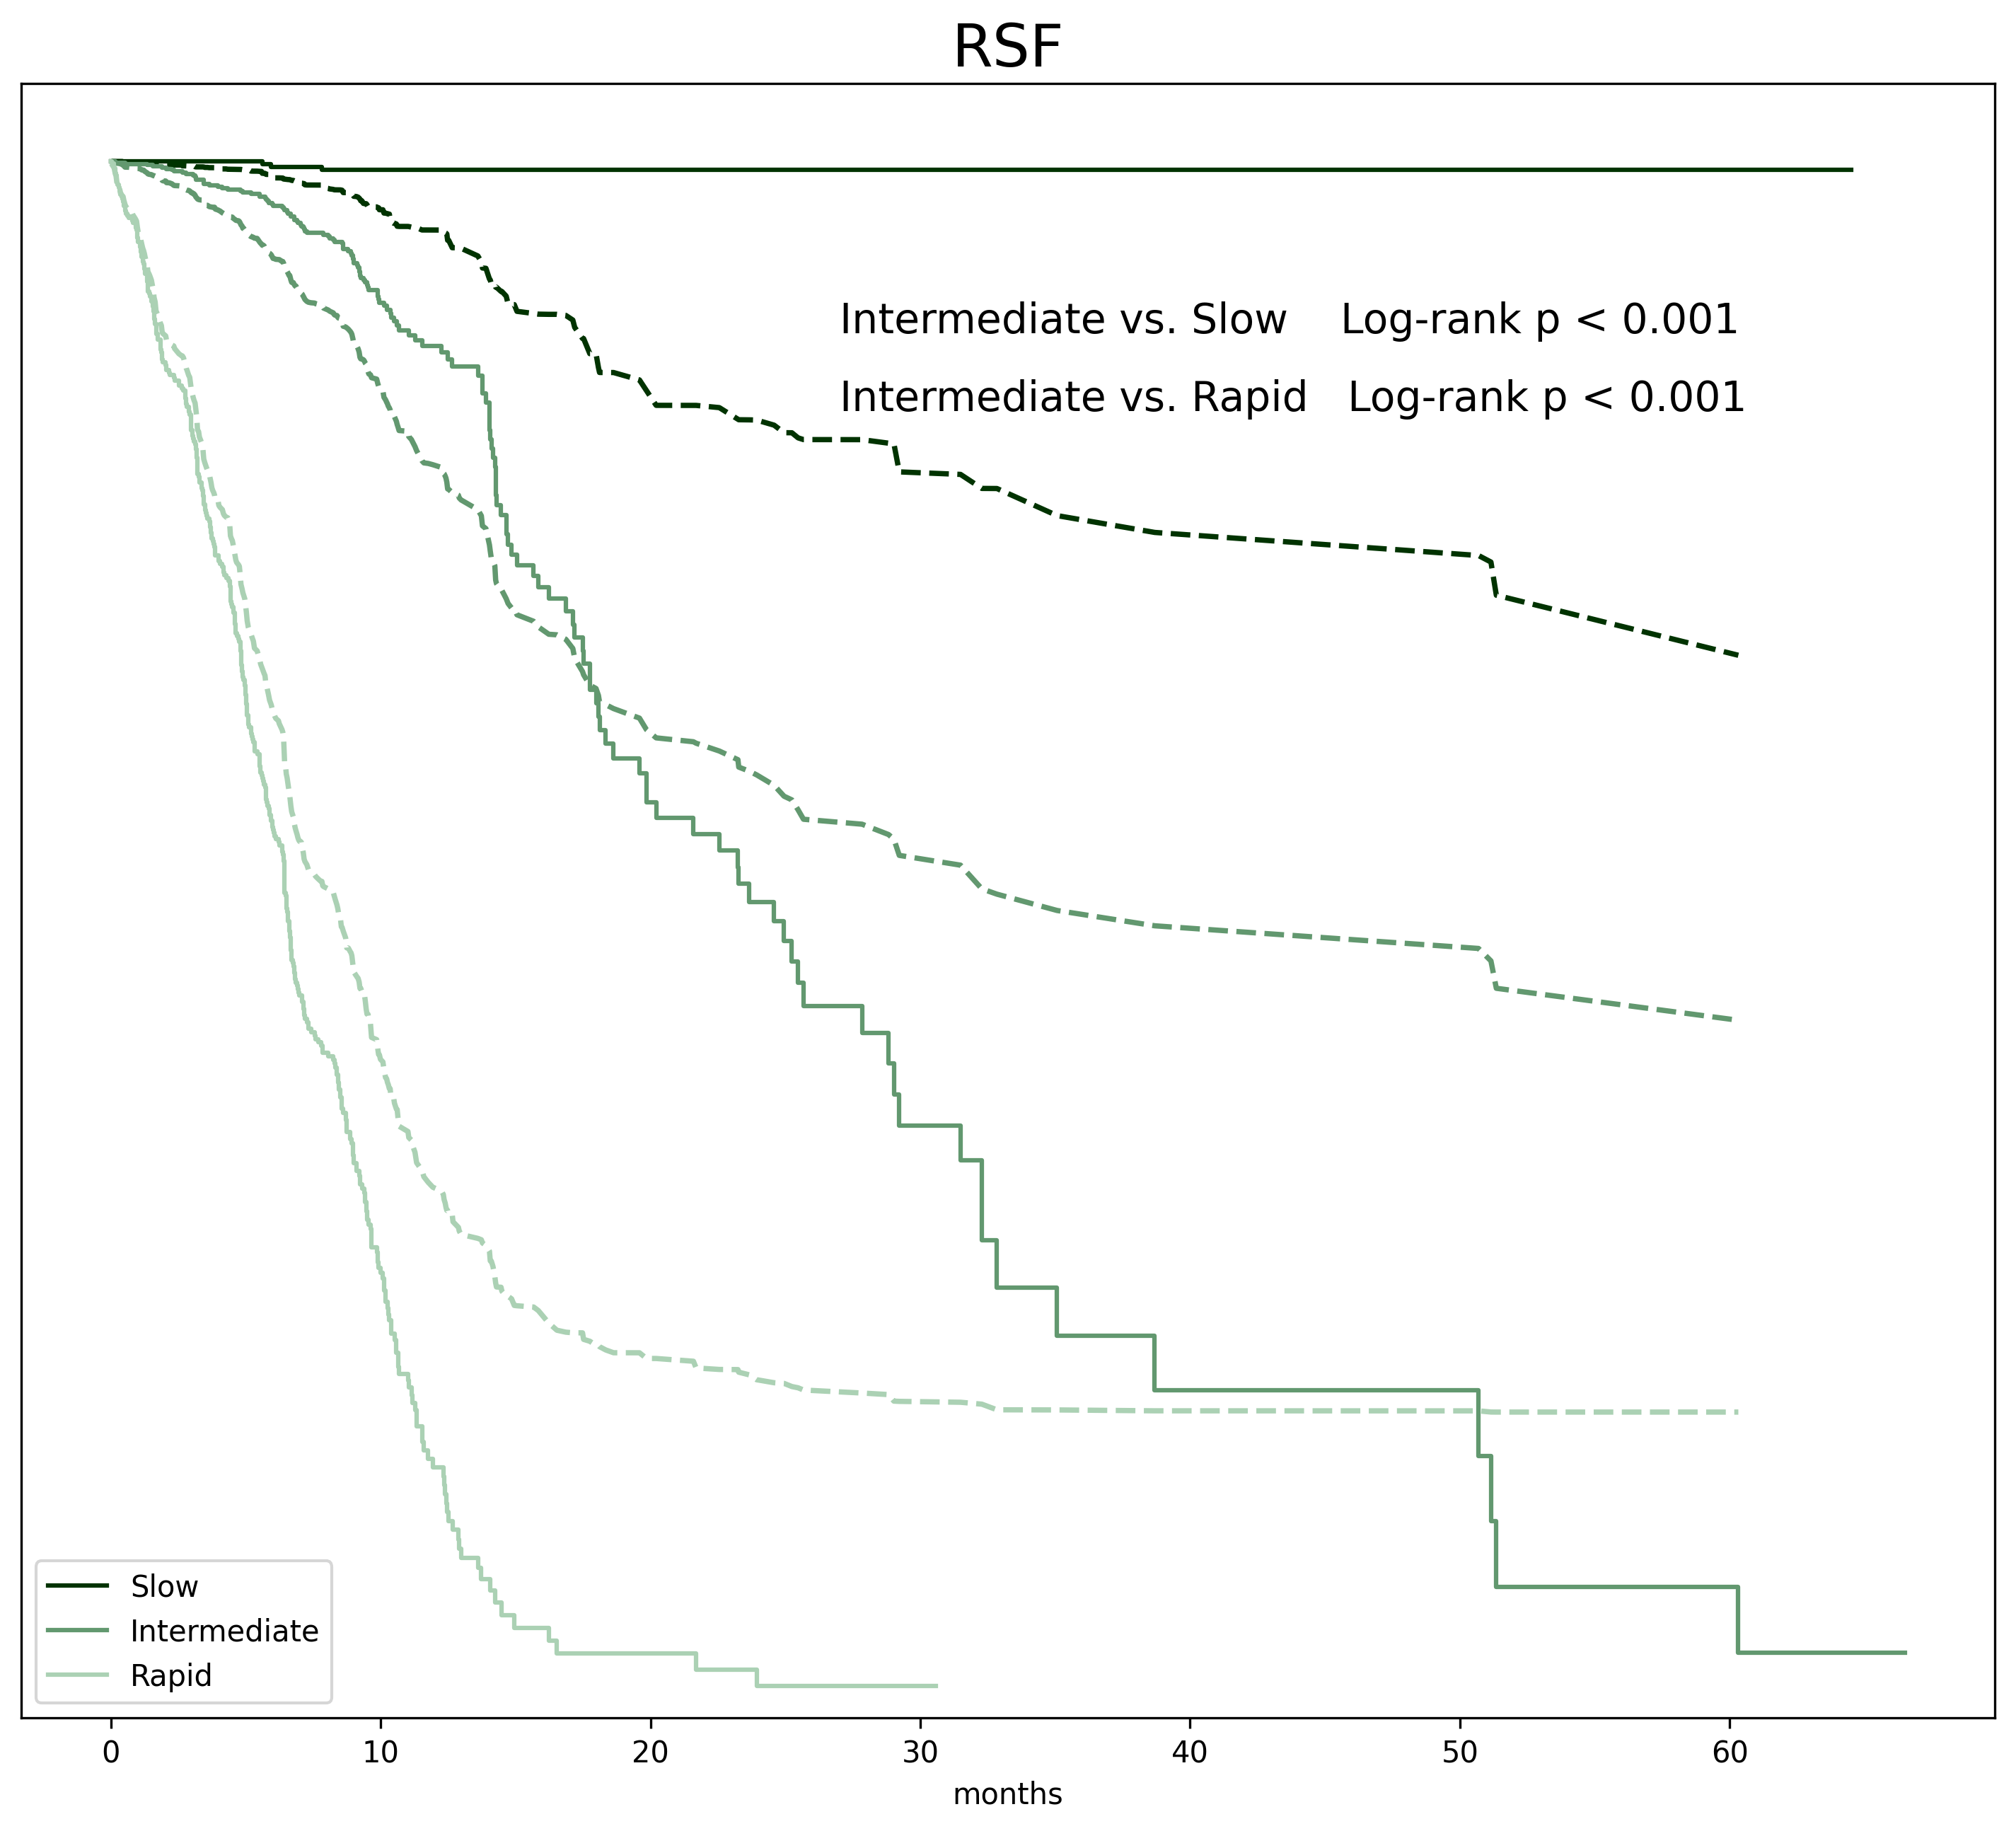

In [ ]:
# Compare KM curve and RSF-prediction curve in each group
# KM in solid lines, pred curve in dotted lines
plt.figure(figsize=(12,10))

OPT = kmf.fit(X_rsf_slow["time_LOA"], X_rsf_slow["status_LOA"], label='Slow', alpha=1)
ax_kmf = OPT.plot(color='#003300', linewidth=1.5)
plt.plot(result_rsf_slow.index, result_rsf_slow[0], marker='None', color='#003300', linestyle="--", linewidth=1.8)


OPT = kmf.fit(X_rsf_intermediate["time_LOA"], X_rsf_intermediate["status_LOA"], label='Intermediate', alpha=1)
ax_kmf = OPT.plot(color='#62986F', linewidth=1.5)
plt.title("Intermediate")
plt.plot(result_rsf_intermediate.index, result_rsf_intermediate[0], marker='None', color='#62986F', linestyle="--", linewidth=1.8)

OPT = kmf.fit(X_rsf_rapid["time_LOA"], X_rsf_rapid["status_LOA"], label='Rapid', alpha=1)
ax_kmf = OPT.plot(color='#ABD1B4', linewidth=1.5)
plt.plot(result_rsf_rapid.index, result_rsf_rapid[0], marker='None', color='#ABD1B4', linestyle="--", linewidth=1.8)

# Calculate log-rank test p-value
log_rank_result_si = logrank_test(X_rsf_slow["time_LOA"], X_rsf_intermediate["time_LOA"], X_rsf_slow["status_LOA"], X_rsf_intermediate["status_LOA"])
log_rank_result_ir = logrank_test(X_rsf_intermediate["time_LOA"], X_rsf_rapid["time_LOA"], X_rsf_intermediate["status_LOA"], X_rsf_rapid["status_LOA"])

# Format the p-values as "p < 0.001" if they are less than 0.001
formatted_p_value_si = f'p < 0.001' if log_rank_result_si.p_value < 0.001 else f'p = {log_rank_result_si.p_value:.4f}'
formatted_p_value_ir = f'p < 0.001' if log_rank_result_ir.p_value < 0.001 else f'p = {log_rank_result_ir.p_value:.4f}'

# Add the p-values as annotations to the plots
plt.annotate(f'Intermediate vs. Slow    Log-rank {formatted_p_value_si}', xy=(27,0.89), color='k', fontsize=14)
plt.annotate(f'Intermediate vs. Rapid   Log-rank {formatted_p_value_ir}', xy=(27,0.84), color='k', fontsize=14)


plt.ylim([0,1.05])
plt.yticks([])
plt.xlabel('months')
plt.title('RSF', fontsize=20)

plt.show()

# 1-2. Visualization (5 random individuals)

In [ ]:
df_train[['status_LOA','time_LOA']].iloc[10:15, :] #Pick 5 random patient

In [ ]:
palette = {10:'#5698C6', 11:'#FF9539',   12:'#60B760',   13:'#DB4142',  14: "#AE8CCD"}

fig, ax = plt.subplots(figsize=(13,7))
result_aft = aft.predict_survival_function(df_train[aft_final_feature_list+['status_LOA', 'time_LOA']].iloc[10:15, :])
plt.xlim([0,70])
ax = sns.lineplot(data = result_aft, palette= palette)
ax.set(xlabel='months', ylabel='Survival probability')
ax.set_title("AFT")

In [ ]:
fig, ax = plt.subplots(figsize=(13,7))
result_cph = cph.predict_survival_function(df_train[cph_final_feature_list+['status_LOA', 'time_LOA']].iloc[10:15, :])
ax = sns.lineplot(data = result_cph, palette= palette)
ax.set(xlabel='months')
plt.xlim([0,70])
plt.yticks([])
ax.set_title("COX")

In [ ]:
result_rsf = rsf.predict_survival_function(df_train[rsf_final_feature_list].iloc[10:15, :], return_array=True)
fig, ax = plt.subplots(figsize=(13,7))
for i, s in enumerate(result_rsf):
    plt.step(rsf.event_times_, s, where="post")

plt.legend(labels = list(df_train[rsf_final_feature_list].iloc[10:15, :].index))
plt.xlabel("months")
plt.xlim([0,70])
plt.yticks([])
plt.title("RSF")
plt.show()

# 2. Check Multicolinearity

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(12,10))
plt.title('Pearson Correlation between Features', y=1.05, size=12)
sns.heatmap(df_train.drop(columns = ['SubjectID', 'time_LOA', 'status_LOA']).astype(float).corr(), linewidths=0.1, vmax=1.0,
   square=True, cmap=colormap, linecolor='white', annot=False)
# 'diag_delta' highly related to 'onset_delta'
# 'mean_Q3_Swallowing' highly related to 'mean_bulbar'

# 3. Comparison of the time to event: Loss of autonomy vs. Gastrostomy placement

## (1) PRO-ACT data

### (i) Time to Gastrostomy = first time of 'ALSFRS Q5b is not NaN'

#### Extract Q5a, Q5b data

In [ ]:
def extract_time_resolved_feature(df, feature_list):
  df_final = df[df['feature_name'] == feature_list[0]][['SubjectID', 'feature_value', 'feature_delta']].rename(columns = {'feature_value': feature_list[0]})

  del feature_list[0]
  for x in feature_list:
    df_add = df[df['feature_name'] == x][['SubjectID', 'feature_value', 'feature_delta']].rename(columns = {'feature_value': x})
    df_final = pd.merge(df_final,df_add, on=['SubjectID','feature_delta'], how='outer')

  return df_final

In [ ]:
#Extract ALSFRS_R_Q5a & Q5b score
ALSFRS_R_raw = study_population.query("form_name == 'ALSFRS'").astype({'feature_delta':'float'})
ALSFRS_R_Q5 = extract_time_resolved_feature(ALSFRS_R_raw, ['Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy'])
ALSFRS_R_Q5 = ALSFRS_R_Q5[['SubjectID', 'feature_delta', 'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy']]
ALSFRS_R_Q5

,SubjectID,feature_delta,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy
0,12808.0,0.0,3,NaN
1,12808.0,32.0,1,NaN
2,12808.0,62.0,1,NaN
3,12808.0,90.0,1,NaN
4,12808.0,118.0,1,NaN
...,...,...,...,...
26821,995893.0,410.0,NaN,0
26822,996711.0,379.0,NaN,4
26823,996711.0,401.0,NaN,4
26824,996711.0,436.0,NaN,4


In [ ]:
# Check if both Q5a, q5b values are NaN
result = ALSFRS_R_Q5[(ALSFRS_R_Q5['Q5a_Cutting_without_Gastrostomy'] == np.NaN) & (ALSFRS_R_Q5['Q5b_Cutting_with_Gastrostomy'] == np.NaN)]

if not result.empty:
    print("Rows where both Q5a, Q5b values are NaN found:")
    print(result)
else:
    print("No rows where both Q5a, Q5b values are NaN.")

No rows where both Q5a, Q5b values are NaN.


In [ ]:
# Check if both Q5a, q5b values exist
result = ALSFRS_R_Q5[~(ALSFRS_R_Q5['Q5a_Cutting_without_Gastrostomy'].isna() | ALSFRS_R_Q5['Q5b_Cutting_with_Gastrostomy'].isna())]

if not result.empty:
    print("Rows where both Q5a, Q5b values exist found:")
    print(result)
else:
    print("No rows where both Q5a, Q5b values exist.")

Rows where both Q5a, Q5b values exist found:
       SubjectID  feature_delta Q5a_Cutting_without_Gastrostomy  \
11971   872882.0          379.0                             3.0   
11972   872882.0          142.0                             3.0   
11973   872882.0           77.0                             3.0   
11974   872882.0          323.0                             3.0   

      Q5b_Cutting_with_Gastrostomy  
11971                          3.0  
11972                          3.0  
11973                          3.0  
11974                          3.0  


In [ ]:
# Delete SubjectID 872882 because both Q5a, Q5b value exists
ALSFRS_R_Q5 = ALSFRS_R_Q5[ALSFRS_R_Q5['SubjectID']!= 872882.0]
ALSFRS_R_Q5

,SubjectID,feature_delta,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy
0,12808.0,0.0,3,NaN
1,12808.0,32.0,1,NaN
2,12808.0,62.0,1,NaN
3,12808.0,90.0,1,NaN
4,12808.0,118.0,1,NaN
...,...,...,...,...
26821,995893.0,410.0,NaN,0
26822,996711.0,379.0,NaN,4
26823,996711.0,401.0,NaN,4
26824,996711.0,436.0,NaN,4


In [ ]:
# Convert scale 'days' to 'month'
ALSFRS_R_Q5[['feature_delta']] = round((ALSFRS_R_Q5[['feature_delta']]/365)*12,2)

# Sort SubjectID and feature delta in ascending order
ALSFRS_R_Q5 = ALSFRS_R_Q5.query('feature_delta >= 0')
ALSFRS_R_Q5 = ALSFRS_R_Q5.sort_values(by=[ALSFRS_R_Q5.columns[0],ALSFRS_R_Q5.columns[1]],ascending=True)
ALSFRS_R_Q5

<ipython-input-47-e144eb608e21>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ALSFRS_R_Q5[['feature_delta']] = round((ALSFRS_R_Q5[['feature_delta']]/365)*12,2)


,SubjectID,feature_delta,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy
14442,348.0,0.00,2,NaN
14443,348.0,0.13,2,NaN
14444,348.0,1.71,2,NaN
14445,348.0,2.01,2,NaN
14446,348.0,3.25,2,NaN
...,...,...,...,...
13538,999990.0,0.39,1.0,NaN
13541,999990.0,1.32,1.0,NaN
13542,999990.0,2.24,1.0,NaN
13539,999990.0,3.19,0.0,NaN


In [ ]:
print("ALSFRS_Q5 contains", len(ALSFRS_R_Q5['SubjectID'].unique().tolist()), " patients")

ALSFRS_Q5 contains 2669  patients


In [ ]:
ALSFRS_R_Q5 = ALSFRS_R_Q5.astype('float')
ALSFRS_R_Q5.dtypes

SubjectID                          float64
feature_delta                      float64
Q5a_Cutting_without_Gastrostomy    float64
Q5b_Cutting_with_Gastrostomy       float64
dtype: object

#### Extract 'Time_to_gastrostomy'

In [ ]:
# Find the first time of [ALSFRS_Q5b is not NaN]
Target_event = ALSFRS_R_Q5[ALSFRS_R_Q5['Q5b_Cutting_with_Gastrostomy'].notna()].groupby('SubjectID').agg(['first']).reset_index()
Target_event.head()

,SubjectID,feature_delta,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy
,,first,first,first
0,533.0,9.44,NaN,4.0
1,902.0,0.23,NaN,4.0
2,1736.0,0.00,NaN,1.0
3,4918.0,0.00,NaN,3.0
4,5879.0,0.46,NaN,1.0


In [ ]:
# Coding [ALSFRS_Q5b is not NaN] event as '1'
Target_event_1 = Target_event[[('SubjectID',''), ('feature_delta', 'first')]]
Target_event_1.columns = ['SubjectID', 'time_GAS']

Target_event_1_subject_list = list(Target_event['SubjectID'])

Target_event_1['status_GAS'] = 1
print("There are",len(Target_event_1['SubjectID'].unique()), "subjects whose Gastrostomy = 1")

# Otherwise '0'
Target_event_0 = ALSFRS_R_Q5[~ALSFRS_R_Q5['SubjectID'].isin(Target_event_1_subject_list)]
Target_event_0 = Target_event_0.groupby('SubjectID').agg(['last']).reset_index().drop(columns=[('Q5a_Cutting_without_Gastrostomy', 'last'), ('Q5b_Cutting_with_Gastrostomy', 'last')])
Target_event_0.columns = ['SubjectID', 'time_GAS']
Target_event_0['status_GAS'] = 0
print("There are",len(Target_event_0['SubjectID'].unique()), "subjects whose Gastrostomy = 0")

# There are 929 subjects whose Gastrostomy = 1
# There are 1740 subjects whose Gastrostomy = 0

There are 929 subjects whose Gastrostomy = 1
There are 1740 subjects whose Gastrostomy = 0


<ipython-input-51-7dc4c2fd3d50>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Target_event_1['status_GAS'] = 1


In [ ]:
ALFRS_Q5_coded = pd.concat([Target_event_1, Target_event_0]).sort_values(by='SubjectID', axis=0)
ALFRS_Q5_coded = ALFRS_Q5_coded.reset_index()
ALFRS_Q5_coded.drop(columns='index', inplace=True)

Target_Data = ALFRS_Q5_coded.copy()
Target_Data_subject_list = list(Target_Data['SubjectID'])
Target_Data #2669 data

,SubjectID,time_GAS,status_GAS
0,348.0,13.18,0
1,533.0,9.44,1
2,902.0,0.23,1
3,1736.0,0.00,1
4,3971.0,12.43,0
...,...,...,...
2664,996981.0,6.12,0
2665,997829.0,6.08,0
2666,999166.0,12.82,0
2667,999823.0,0.30,1


#### Exclude; event or censoring occurred within 3 months after enrollment (to compare with time to LOA, we apply same exclusion criteria)

<Axes: xlabel='time_GAS', ylabel='Count'>

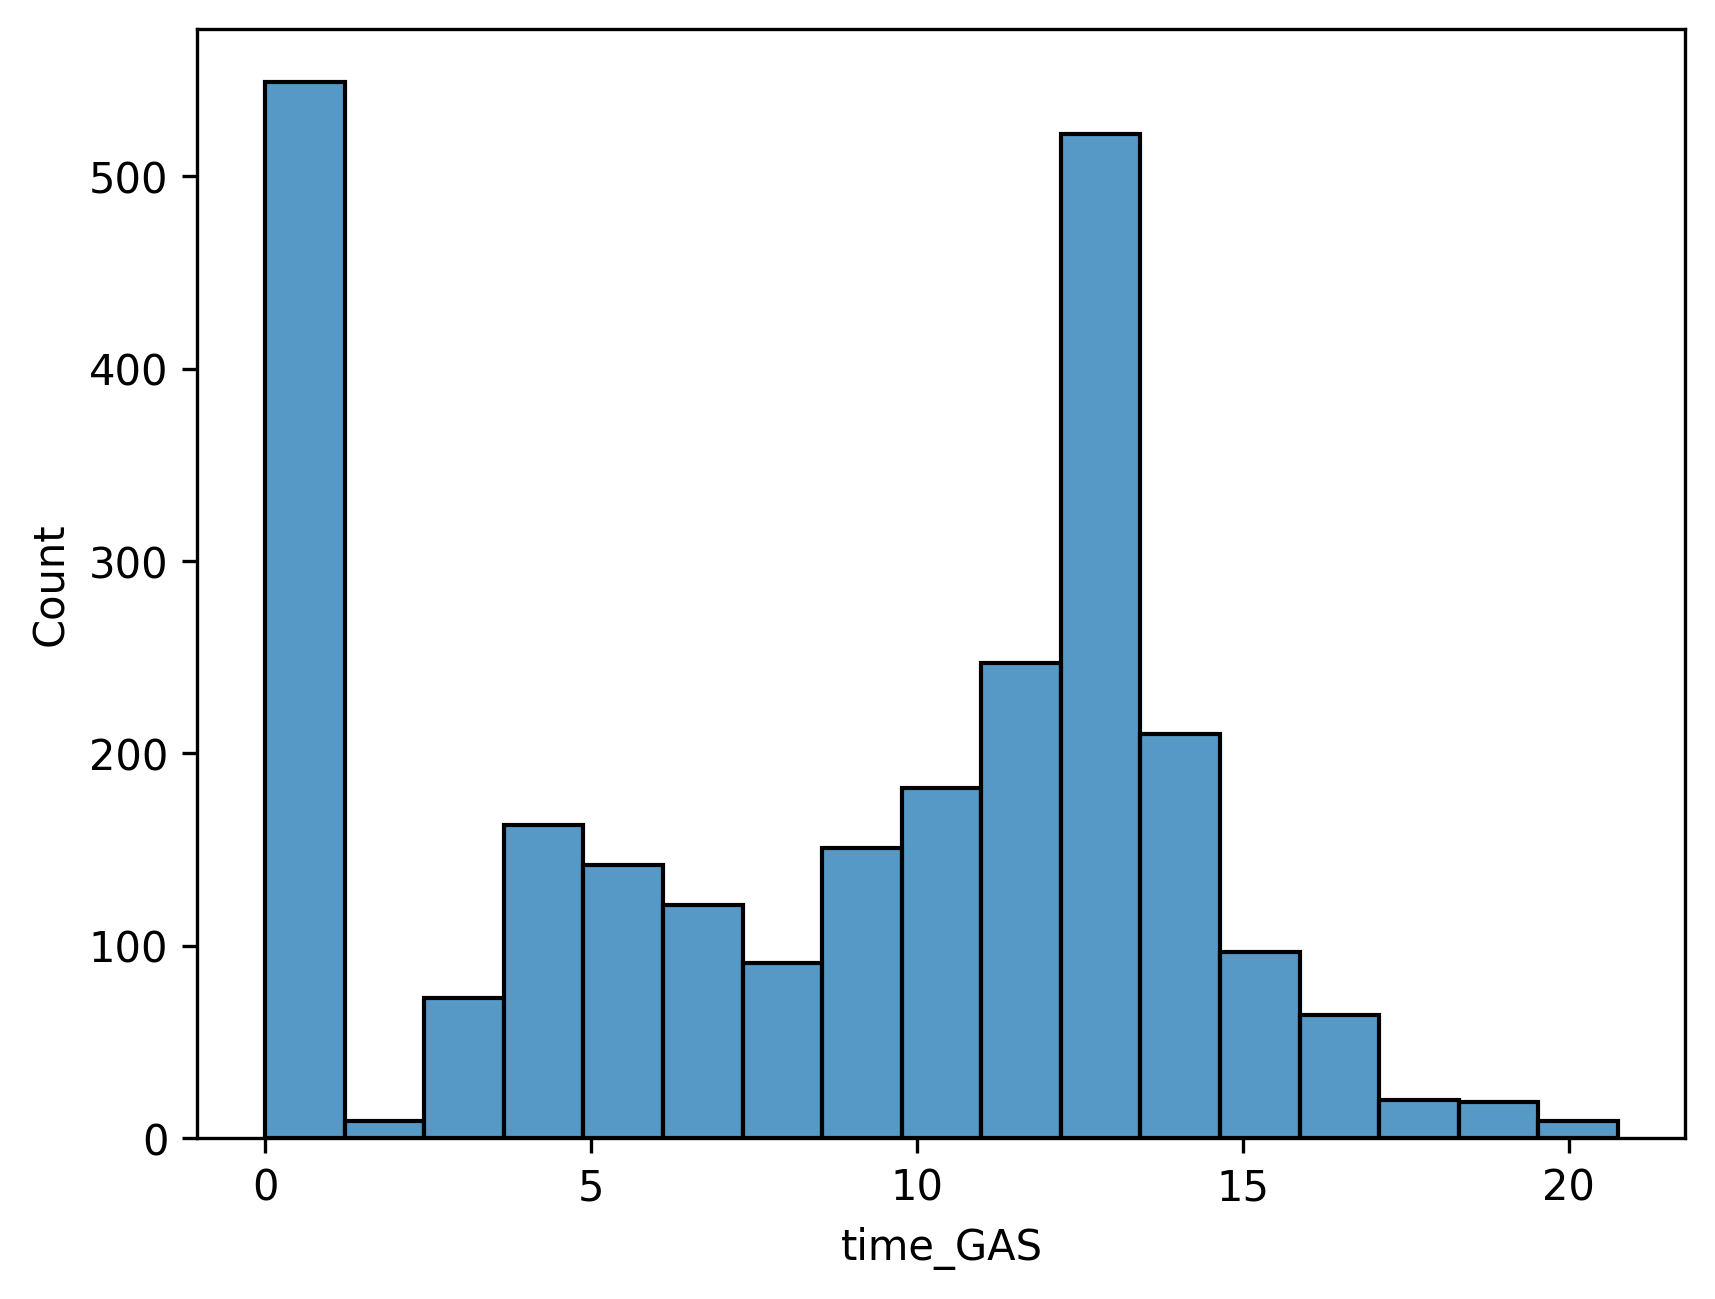

In [ ]:
sns.histplot(Target_Data['time_GAS'])

In [ ]:
Target_Data.query('time_GAS <= 3.0')

,SubjectID,time_GAS,status_GAS
2,902.0,0.23,1
3,1736.0,0.00,1
8,4918.0,0.00,1
10,5879.0,0.46,1
20,8258.0,0.00,1
...,...,...,...
2603,974907.0,0.00,1
2610,978851.0,0.00,1
2651,992560.0,0.00,1
2652,992712.0,0.00,1


In [ ]:
print(len(Target_Data.query('time_GAS <= 3.0')['SubjectID'].tolist()), 'patients has time_GAS 3 month or less')

563 patients has time_GAS 3 month or less


In [ ]:
Target_Data_final = Target_Data.query('time_GAS > 3.0')

# minus 3months for target data value
Target_Data_final['time_GAS'] = Target_Data_final['time_GAS'] -3.0

GAS = Target_Data_final
GAS

<ipython-input-56-a4f830bcfff6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Target_Data_final['time_GAS'] = Target_Data_final['time_GAS'] -3.0


,SubjectID,time_GAS,status_GAS
0,348.0,10.18,0
1,533.0,6.44,1
4,3971.0,9.43,0
5,4752.0,9.69,0
6,4796.0,4.56,0
...,...,...,...
2663,996808.0,12.16,0
2664,996981.0,3.12,0
2665,997829.0,3.08,0
2666,999166.0,9.82,0


In [ ]:
print(len(Target_Data['SubjectID'])-len(Target_Data_final['SubjectID']), 'patients were excluded because of early occurrence or censoring')
print(len(Target_Data.query('(time_GAS <= 3.0) and (status_GAS == 0)')), 'out of 563 are early censored (follow up being < 3mo)')
print(len(Target_Data.query('(time_GAS <= 3.0) and (status_GAS == 1)')), 'out of 563 are early occured (occurred before 3mo)')

563 patients were excluded because of early occurrence or censoring
0 out of 563 are early censored (follow up being < 3mo)
563 out of 563 are early occured (occurred before 3mo)


In [ ]:
# Note that 'time_GAS' is month scaled

In [ ]:
LOA = proact_train_set[['SubjectID','time_LOA', 'status_LOA']]
LOA

,SubjectID,time_LOA,status_LOA
0,348.0,10.18,0.0
1,533.0,6.44,1.0
2,902.0,2.06,0.0
3,1736.0,5.02,1.0
4,3971.0,9.43,0.0
...,...,...,...
2665,996981.0,3.12,0.0
2666,997829.0,3.08,0.0
2667,999166.0,9.82,0.0
2668,999823.0,3.05,0.0


In [ ]:
# Check the proportion of censored data
print("There are ", len(LOA[LOA['status_LOA']==0]), "censored data in",len(LOA), " Loss of Autonomy")
print("There are ", len(GAS[GAS['status_GAS']==0]), "censored data in",len(GAS), " gastrostomy")

There are  2093 censored data in 2670  Loss of Autonomy
There are  1740 censored data in 2106  gastrostomy


### (ii) KM estimation on each target

In [ ]:
merged_target = pd.merge(LOA, GAS, on='SubjectID', how='inner')
merged_target

,SubjectID,time_LOA,status_LOA,time_GAS,status_GAS
0,348.0,10.18,0.0,10.18,0
1,533.0,6.44,1.0,6.44,1
2,3971.0,9.43,0.0,9.43,0
3,4752.0,9.69,0.0,9.69,0
4,4796.0,4.56,0.0,4.56,0
...,...,...,...,...,...
2101,996808.0,12.16,0.0,12.16,0
2102,996981.0,3.12,0.0,3.12,0
2103,997829.0,3.08,0.0,3.08,0
2104,999166.0,9.82,0.0,9.82,0


In [ ]:
merged_target = merged_target.query("SubjectID=={0}".format(study_population['SubjectID'].unique().tolist()))
merged_target

,SubjectID,time_LOA,status_LOA,time_GAS,status_GAS
0,348.0,10.18,0.0,10.18,0
1,533.0,6.44,1.0,6.44,1
2,3971.0,9.43,0.0,9.43,0
3,4752.0,9.69,0.0,9.69,0
4,4796.0,4.56,0.0,4.56,0
...,...,...,...,...,...
2101,996808.0,12.16,0.0,12.16,0
2102,996981.0,3.12,0.0,3.12,0
2103,997829.0,3.08,0.0,3.08,0
2104,999166.0,9.82,0.0,9.82,0


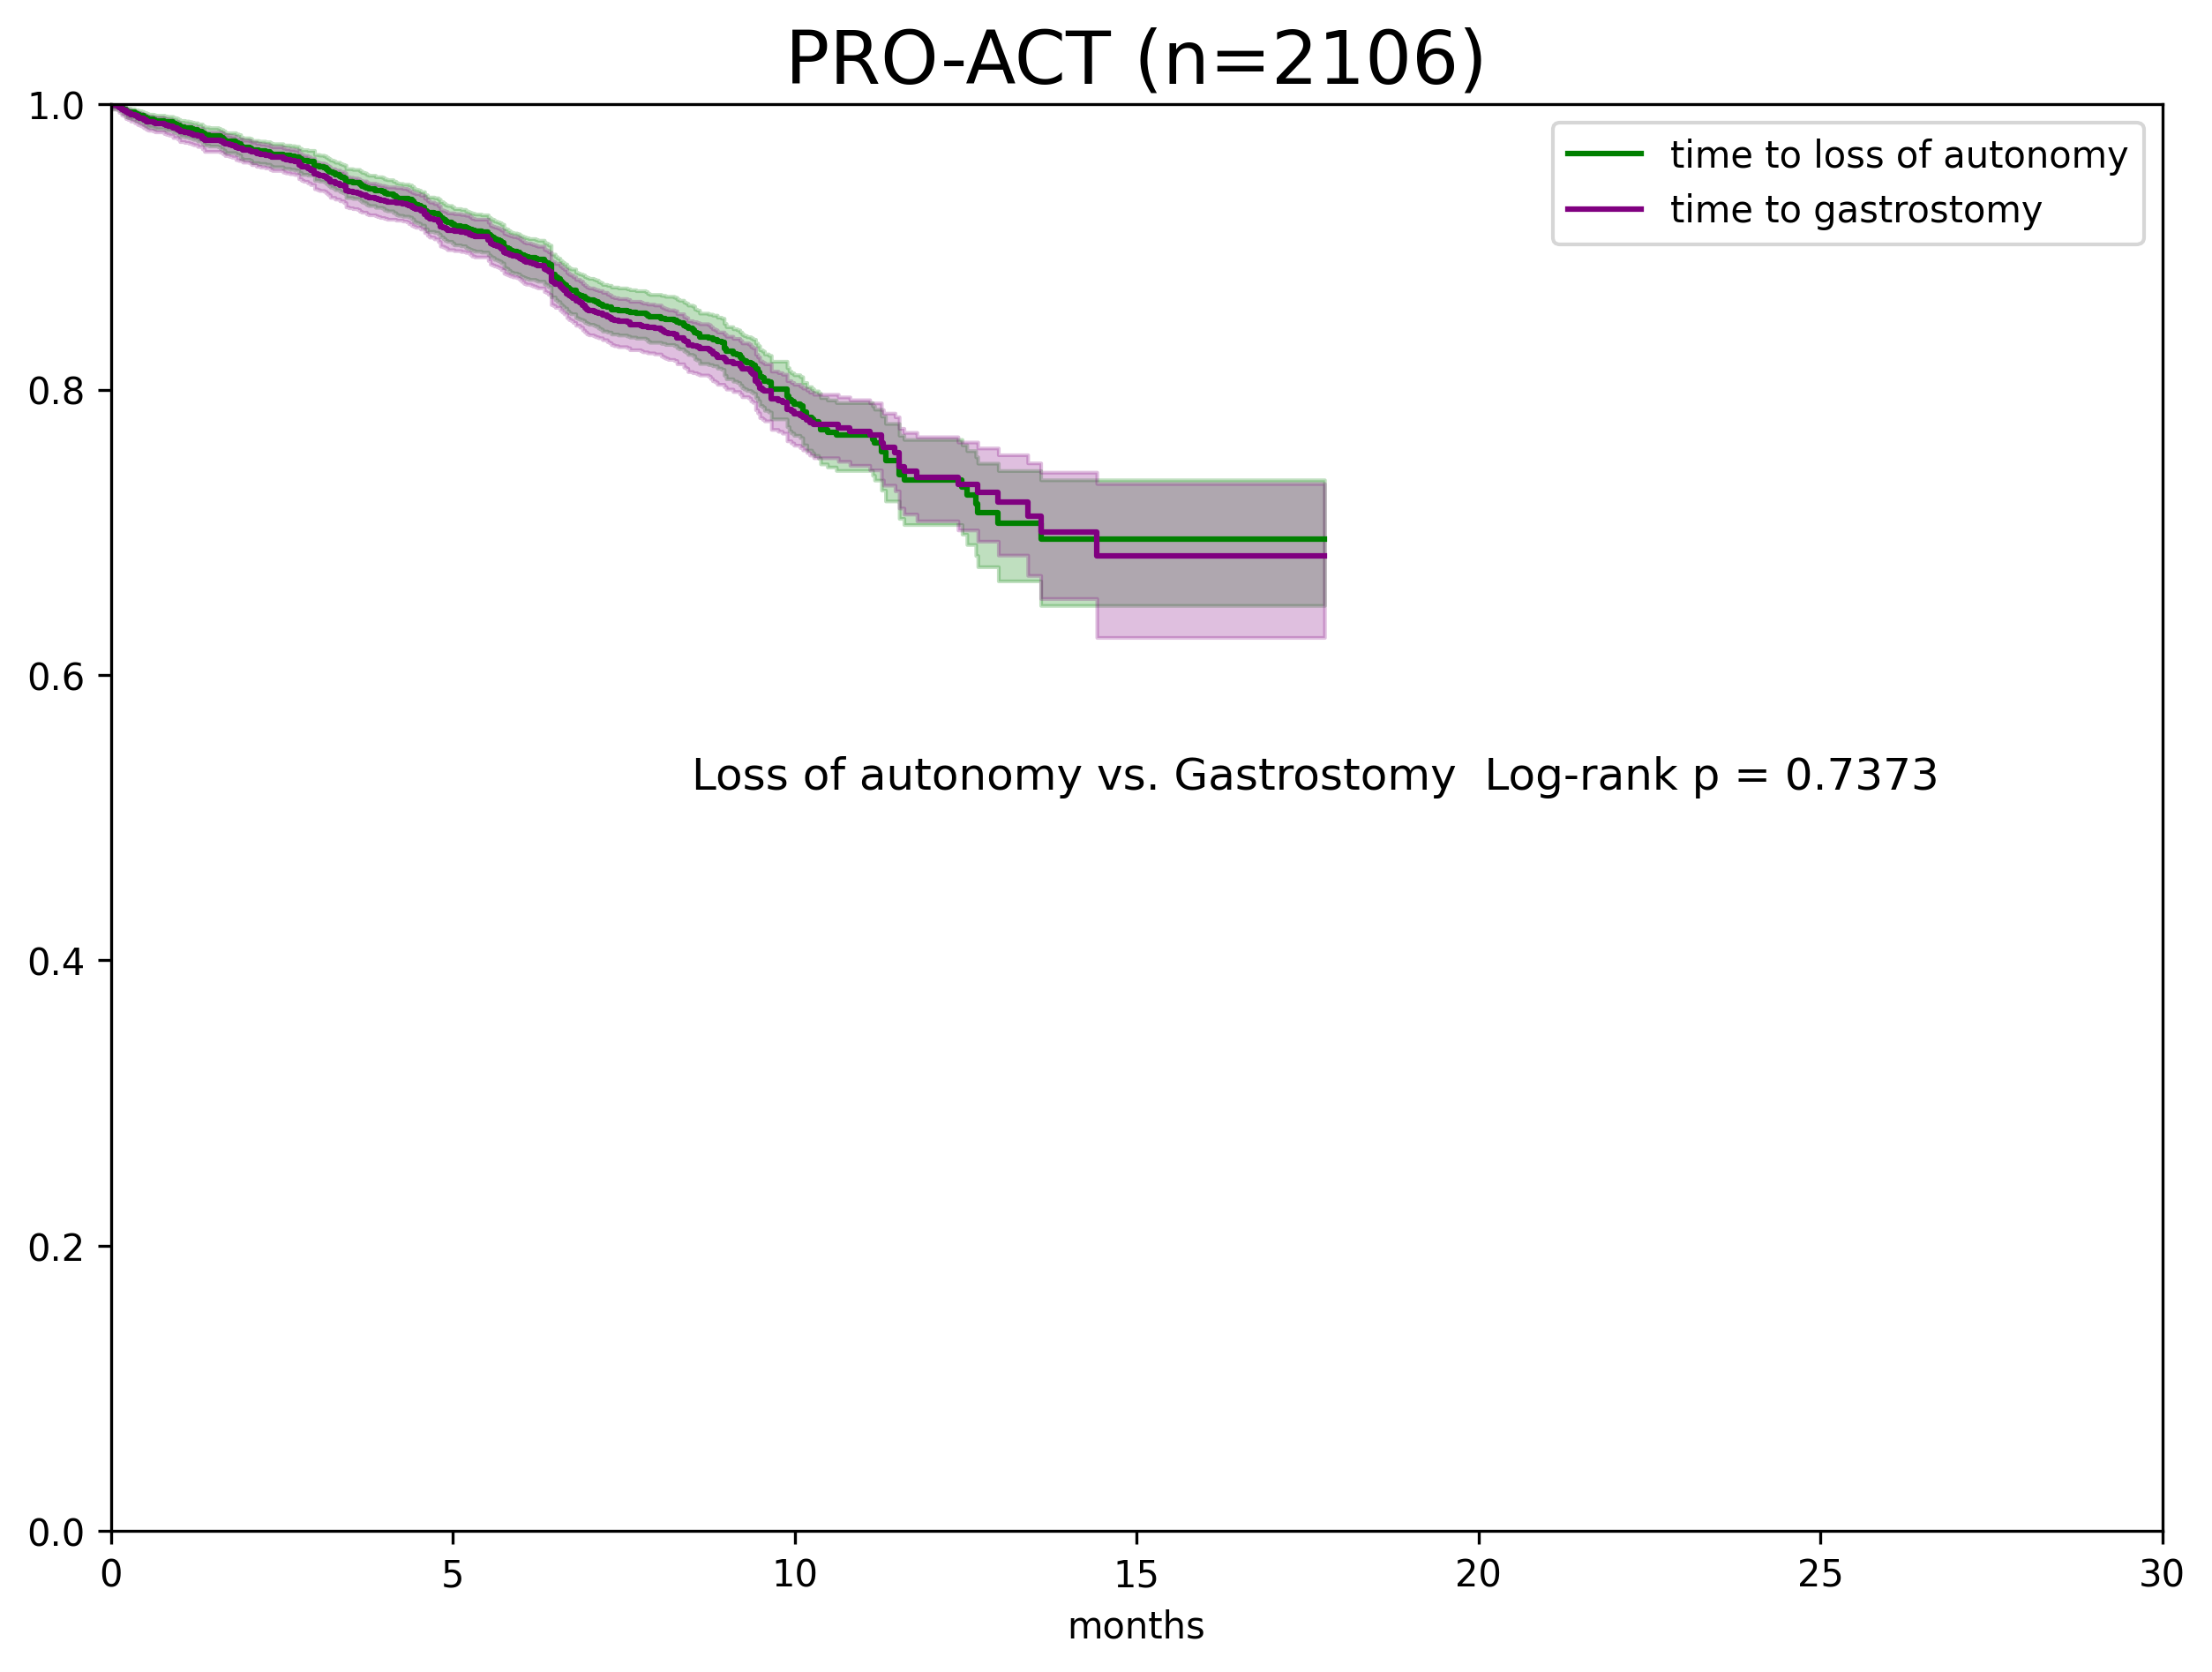

In [ ]:
from lifelines.statistics import logrank_test
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 7))

# Calculate log-rank test p-value
log_rank_result = logrank_test(merged_target["time_LOA"], merged_target["time_GAS"], merged_target["status_LOA"], merged_target["status_GAS"])

LOA_plot = kmf.fit(merged_target["time_LOA"], merged_target["status_LOA"], label='time to loss of autonomy')
ax_kmf = LOA_plot.plot(color='green')
plt.xlim([0,30])
plt.ylim([0,1])

GAS_plot = kmf.fit(merged_target['time_GAS'], merged_target['status_GAS'], label='time to gastrostomy')
ax_kmf2 = GAS_plot.plot(color='purple')
plt.xlim([0,30])
plt.ylim([0,1])

plt.annotate(f'Loss of autonomy vs. Gastrostomy  Log-rank p = {log_rank_result.p_value:.4f}', xy=(8.5, 0.52), color='k', fontsize=12)
plt.xlabel('months')
plt.title('PRO-ACT (n=2106)', fontsize=20)
plt.show()

### (iii) Scatterplot of time_LOA & time_GAS

In [ ]:
print("There are ", len(merged_target.query('status_LOA ==1 and status_GAS ==1')), "occurred data in",len(merged_target), " merged target")

There are  322 occurred data in 2106  merged target


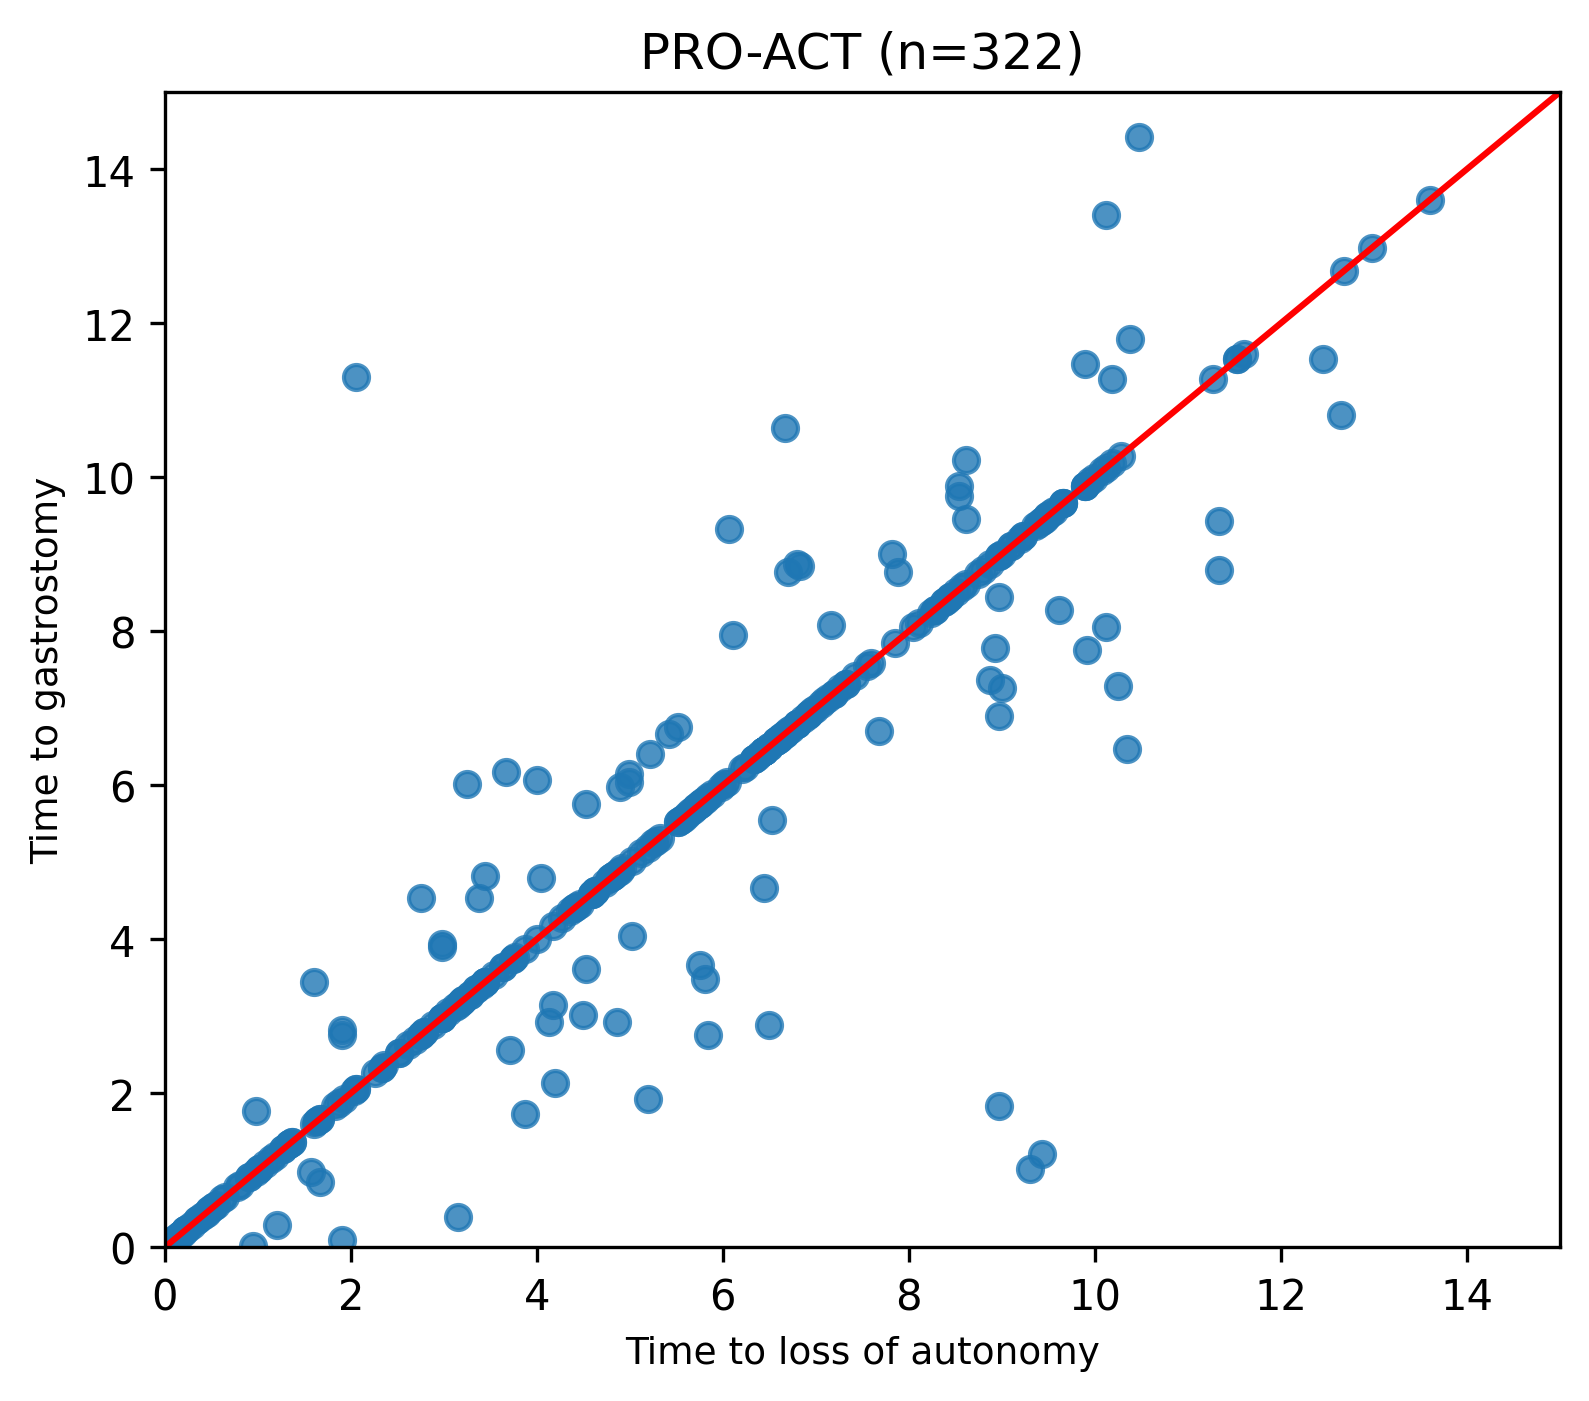

In [ ]:
scat_df = merged_target.query('status_LOA ==1 and status_GAS ==1')
fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(x=scat_df['time_LOA'], y=scat_df['time_GAS'], fit_reg=False)
plt.xlabel('Time to loss of autonomy', fontsize=9)
plt.ylabel('Time to gastrostomy', fontsize=9)
plt.title('PRO-ACT (n=322)')
ax.plot([0,1],[0,1], transform=ax.transAxes, color='red') # y=x line
plt.xlim([0,15])
plt.ylim([0,15])
plt.show() # shows enough match

## (2) SNUH data

### (i) Time to Gastrostomy = first time of 'ALSFRS Q5b is not NaN'

#### Extract Q5a, Q5b data

In [ ]:
#Change column name and drop unnecessary columns
snuh_frs1.columns = ['Hosp_ID', 'Date_visit_time', 'Date_visit', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking', 'Q9_Climbing_Stairs', 'R1_Dyspnea', 'R2_Orthopnea', 'R3_Respiratory_Insufficiency', 'ALSFRS_R_Total', 'MiToS stage(0-5)', 'ALSFRS_Total']
snuh_frs1 = snuh_frs1.drop(columns=['Date_visit_time', 'MiToS stage(0-5)', 'ALSFRS_Total'])

snuh_frs2.columns = ['Hosp_ID', 'Date_visit_time', 'Date_visit', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking', 'Q9_Climbing_Stairs', 'R1_Dyspnea', 'R2_Orthopnea', 'R3_Respiratory_Insufficiency', 'ALSFRS_R_Total', 'MiToS stage(0-5)']
snuh_frs2 = snuh_frs2.drop(columns=['Date_visit_time', 'MiToS stage(0-5)'])

In [ ]:
frs = pd.concat([snuh_frs1, snuh_frs2])
frs

,Hosp_ID,Date_visit,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total
0,49410075,2017-04-24,3.0,4.0,3.0,2.0,2.0,NaN,2.0,1.0,3.0,1.0,4.0,4.0,4.0,33.0
1,48147002,2017-04-24,2.0,1.0,2.0,3.0,3.0,NaN,2.0,1.0,3.0,3.0,4.0,4.0,4.0,32.0
2,48873185,2017-04-24,4.0,4.0,4.0,3.0,4.0,NaN,3.0,3.0,3.0,2.0,4.0,4.0,4.0,42.0
3,31089470,2017-04-24,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,12.0
4,49244317,2017-04-26,4.0,4.0,4.0,4.0,NaN,3.0,3.0,3.0,2.0,1.0,4.0,4.0,4.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,54000759,2021-07-26,4.0,3.0,2.0,3.0,NaN,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,42.0
1199,41158366,2021-07-26,3.0,3.0,3.0,3.0,3.0,NaN,4.0,2.0,3.0,3.0,4.0,4.0,4.0,39.0
1200,52143496,2021-07-26,3.0,4.0,4.0,1.0,1.0,NaN,1.0,2.0,1.0,1.0,4.0,4.0,4.0,30.0
1201,51065632,2021-07-26,3.0,3.0,3.0,2.0,1.0,NaN,1.0,2.0,1.0,1.0,4.0,3.0,4.0,28.0


##### observations missing visit date

In [ ]:
# Add StudyID column
frs_with_id = pd.merge(frs, base[['Study_ID', 'Hosp_ID']], on='Hosp_ID', how='inner')

In [ ]:
#Select 214 patients (that we used for external validation)
filtered_list = X_with_nans_snuh['SubjectID'].unique().tolist()
frs_with_id = frs_with_id.query("Study_ID == {0}".format(filtered_list))

In [ ]:
frs_with_id[frs_with_id['Date_visit'].isnull()==True] #64 observations are deleted because their Date_visit is missing

,Hosp_ID,Date_visit,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total,Study_ID
45,44753599,NaN,2.0,3.0,3.0,0.0,1.0,NaN,1.0,2.0,2.0,1.0,4.0,4.0,4.0,27.0,1145.0
64,49332276,NaN,4.0,4.0,4.0,0.0,0.0,NaN,0.0,1.0,2.0,1.0,4.0,4.0,4.0,28.0,1005.0
65,49332276,NaN,3.0,4.0,4.0,0.0,2.0,NaN,1.0,2.0,3.0,1.0,4.0,4.0,4.0,32.0,1005.0
76,49469116,NaN,4.0,4.0,4.0,3.0,3.0,NaN,2.0,3.0,3.0,3.0,3.0,3.0,4.0,39.0,1030.0
84,49460296,NaN,4.0,4.0,4.0,3.0,3.0,NaN,2.0,2.0,3.0,2.0,4.0,4.0,4.0,39.0,1031.0
161,30947504,NaN,3.0,2.0,4.0,3.0,3.0,NaN,3.0,4.0,4.0,1.0,4.0,4.0,4.0,39.0,1046.0
162,30947504,NaN,3.0,2.0,3.0,3.0,3.0,NaN,3.0,4.0,3.0,3.0,3.0,4.0,4.0,38.0,1046.0
231,19633358,NaN,0.0,0.0,0.0,3.0,NaN,1.0,1.0,2.0,3.0,2.0,2.0,2.0,4.0,20.0,1063.0
305,47242315,NaN,3.0,3.0,2.0,3.0,3.0,NaN,3.0,3.0,2.0,1.0,3.0,2.0,4.0,32.0,1078.0
322,34599983,NaN,2.0,4.0,3.0,3.0,3.0,NaN,3.0,3.0,2.0,1.0,4.0,4.0,4.0,36.0,1083.0


In [ ]:
frs_with_id = frs_with_id[frs_with_id['Date_visit'].isnull()==False]

##### duplicates and errorneous observations

In [ ]:
frs_with_id[frs_with_id.duplicated(keep=False)] # 2 observations are duplicated, so only one for each 2 data will be saved

,Hosp_ID,Date_visit,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total,Study_ID
226,49067440,2017-06-12,2.0,4.0,3.0,2.0,2.0,NaN,1.0,2.0,3.0,1.0,3.0,3.0,4.0,30.0,1062.0
228,49067440,2017-06-12,2.0,4.0,3.0,2.0,2.0,NaN,1.0,2.0,3.0,1.0,3.0,3.0,4.0,30.0,1062.0
1725,52978281,2019-12-23,4.0,4.0,4.0,3.0,2.0,NaN,2.0,2.0,3.0,1.0,4.0,4.0,4.0,37.0,1459.0
1726,52978281,2019-12-23,4.0,4.0,4.0,3.0,2.0,NaN,2.0,2.0,3.0,1.0,4.0,4.0,4.0,37.0,1459.0


In [ ]:
frs_with_id = frs_with_id.drop_duplicates( keep="first", inplace=False)
frs_with_id

,Hosp_ID,Date_visit,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total,Study_ID
7,48873185,2017-04-24,4.0,4.0,4.0,3.0,4.0,NaN,3.0,3.0,3.0,2.0,4.0,4.0,4.0,42.0,1019.0
8,48873185,2017-07-24,4.0,4.0,3.0,3.0,4.0,NaN,2.0,3.0,3.0,1.0,4.0,4.0,4.0,39.0,1019.0
9,48873185,2017-11-06,3.0,4.0,3.0,3.0,3.0,NaN,2.0,3.0,2.0,1.0,3.0,3.0,4.0,34.0,1019.0
10,48873185,2018-05-28,3.0,4.0,3.0,4.0,NaN,4.0,1.0,3.0,0.0,0.0,1.0,2.0,4.0,29.0,1019.0
11,48873185,2018-08-20,2.0,4.0,2.0,1.0,2.0,NaN,0.0,1.0,1.0,0.0,1.0,3.0,4.0,21.0,1019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,54713000,2021-05-12,2.0,2.0,4.0,4.0,3.0,NaN,3.0,3.0,3.0,3.0,4.0,4.0,4.0,39.0,1650.0
2347,54713000,2021-06-09,2.0,2.0,3.0,3.0,3.0,NaN,3.0,3.0,3.0,2.0,3.0,4.0,4.0,35.0,1650.0
2348,54713000,2021-07-07,1.0,2.0,4.0,3.0,3.0,NaN,3.0,3.0,3.0,3.0,4.0,4.0,4.0,37.0,1650.0
2351,54866098,2021-03-29,4.0,4.0,4.0,4.0,4.0,NaN,4.0,4.0,3.0,3.0,4.0,4.0,4.0,46.0,1654.0


In [ ]:
frs_with_id[frs_with_id.duplicated(subset=['Hosp_ID','Date_visit'], keep=False)] # 2 more observations show different value in same ID, same date, these data will be deleted

,Hosp_ID,Date_visit,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total,Study_ID
86,49460296,2018-03-05,4.0,3.0,3.0,4.0,1.0,NaN,0.0,1.0,1.0,0.0,2.0,3.0,4.0,26.0,1031.0
90,49460296,2018-03-05,4.0,4.0,2.0,2.0,2.0,NaN,1.0,1.0,2.0,0.0,4.0,4.0,4.0,30.0,1031.0
96,42029656,2018-11-05,2.0,2.0,3.0,3.0,3.0,NaN,3.0,2.0,2.0,0.0,4.0,4.0,4.0,32.0,1188.0
97,42029656,2018-11-05,4.0,4.0,4.0,3.0,2.0,NaN,3.0,4.0,3.0,1.0,4.0,4.0,4.0,40.0,1188.0


In [ ]:
frs_with_id = frs_with_id[~frs_with_id.duplicated(subset=['Hosp_ID','Date_visit'], keep=False)]

In [ ]:
# Add Date_enrollment column to calculate feature delta
frs_with_id = pd.merge(frs_with_id.drop(columns=['Hosp_ID']), dx[['Study_ID','Date_enrollment']], on='Study_ID', how='inner')
frs_with_id

,Date_visit,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total,Study_ID,Date_enrollment
0,2017-04-24,4.0,4.0,4.0,3.0,4.0,NaN,3.0,3.0,3.0,2.0,4.0,4.0,4.0,42.0,1019.0,2017-04-24
1,2017-07-24,4.0,4.0,3.0,3.0,4.0,NaN,2.0,3.0,3.0,1.0,4.0,4.0,4.0,39.0,1019.0,2017-04-24
2,2017-11-06,3.0,4.0,3.0,3.0,3.0,NaN,2.0,3.0,2.0,1.0,3.0,3.0,4.0,34.0,1019.0,2017-04-24
3,2018-05-28,3.0,4.0,3.0,4.0,NaN,4.0,1.0,3.0,0.0,0.0,1.0,2.0,4.0,29.0,1019.0,2017-04-24
4,2018-08-20,2.0,4.0,2.0,1.0,2.0,NaN,0.0,1.0,1.0,0.0,1.0,3.0,4.0,21.0,1019.0,2017-04-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,2021-05-12,2.0,2.0,4.0,4.0,3.0,NaN,3.0,3.0,3.0,3.0,4.0,4.0,4.0,39.0,1650.0,2021-03-23
1109,2021-06-09,2.0,2.0,3.0,3.0,3.0,NaN,3.0,3.0,3.0,2.0,3.0,4.0,4.0,35.0,1650.0,2021-03-23
1110,2021-07-07,1.0,2.0,4.0,3.0,3.0,NaN,3.0,3.0,3.0,3.0,4.0,4.0,4.0,37.0,1650.0,2021-03-23
1111,2021-03-29,4.0,4.0,4.0,4.0,4.0,NaN,4.0,4.0,3.0,3.0,4.0,4.0,4.0,46.0,1654.0,2021-03-29


In [ ]:
date_enroll = dx[['Study_ID', 'Date_enrollment']]
date_enroll.columns = ['SubjectID', 'Date_enrollment']

In [ ]:
# Define function returning df with calculated feature delta for time-resolved feautures
def cal_feature_delta(df, date_enroll):
  df1 = pd.merge(df, date_enroll)
  df1['feature_delta'] = (pd.to_datetime(df1['Date_visit'])- pd.to_datetime(df1['Date_enrollment'])) / np.timedelta64(1,'D') * 12/365
  df1 = df1.sort_values(by=['SubjectID', 'feature_delta'], axis=0).reset_index().drop(columns='index')
  df1.drop(columns = ['Date_visit','Date_enrollment'], inplace = True)
  return df1

In [ ]:
frs_with_id.rename(columns = {'Study_ID':'SubjectID'},inplace=True)
alsfrs_R_raw = cal_feature_delta(frs_with_id, date_enroll)

alsfrs_R_raw = alsfrs_R_raw[['SubjectID','feature_delta', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting',
       'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking',
       'Q9_Climbing_Stairs', 'R1_Dyspnea', 'R2_Orthopnea',
       'R3_Respiratory_Insufficiency', 'ALSFRS_R_Total', ]]
alsfrs_R_raw

,SubjectID,feature_delta,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total
0,1005.0,0.920548,4.0,4.0,4.0,1.0,2.0,NaN,1.0,1.0,3.0,1.0,4.0,4.0,4.0,33.0
1,1005.0,7.134247,3.0,4.0,4.0,1.0,1.0,NaN,0.0,2.0,1.0,0.0,4.0,4.0,4.0,28.0
2,1005.0,11.046575,3.0,4.0,3.0,0.0,1.0,NaN,1.0,1.0,2.0,1.0,4.0,4.0,4.0,28.0
3,1005.0,13.808219,4.0,4.0,4.0,0.0,1.0,NaN,0.0,1.0,1.0,0.0,4.0,4.0,4.0,27.0
4,1005.0,16.339726,4.0,4.0,4.0,0.0,1.0,NaN,0.0,1.0,2.0,1.0,4.0,4.0,4.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,11872.0,0.000000,4.0,4.0,4.0,4.0,4.0,NaN,4.0,4.0,2.0,2.0,4.0,4.0,4.0,44.0
1109,11872.0,4.109589,4.0,4.0,4.0,4.0,3.0,NaN,3.0,3.0,2.0,1.0,4.0,4.0,4.0,40.0
1110,11872.0,5.950685,4.0,4.0,4.0,4.0,3.0,NaN,3.0,3.0,1.0,0.0,4.0,4.0,4.0,38.0
1111,11872.0,10.323288,4.0,4.0,4.0,3.0,2.0,NaN,3.0,2.0,1.0,0.0,4.0,4.0,4.0,35.0


In [ ]:
ALSFRS_R_Q5 = alsfrs_R_raw[['SubjectID', 'feature_delta', 'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy']]
ALSFRS_R_Q5

,SubjectID,feature_delta,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy
0,1005.0,0.920548,2.0,NaN
1,1005.0,7.134247,1.0,NaN
2,1005.0,11.046575,1.0,NaN
3,1005.0,13.808219,1.0,NaN
4,1005.0,16.339726,1.0,NaN
...,...,...,...,...
1108,11872.0,0.000000,4.0,NaN
1109,11872.0,4.109589,3.0,NaN
1110,11872.0,5.950685,3.0,NaN
1111,11872.0,10.323288,2.0,NaN


In [ ]:
# Check if both Q5a, Q5b values are NaN
result = ALSFRS_R_Q5[(ALSFRS_R_Q5['Q5a_Cutting_without_Gastrostomy'] == np.NaN) & (ALSFRS_R_Q5['Q5b_Cutting_with_Gastrostomy'] == np.NaN)]

if not result.empty:
    print("Rows where both Q5a, Q5b values are NaN found:")
    print(result)
else:
    print("No rows where both Q5a, Q5b values are NaN.")

No rows where both Q5a, Q5b values are NaN.


In [ ]:
# Check if both Q5a, Q5b values exist
result = ALSFRS_R_Q5[~(ALSFRS_R_Q5['Q5a_Cutting_without_Gastrostomy'].isna() | ALSFRS_R_Q5['Q5b_Cutting_with_Gastrostomy'].isna())]

if not result.empty:
    print("Rows where both Q5a, Q5b values exist found:")
    print(result)
else:
    print("No rows where both Q5a, Q5b values exist.")

No rows where both Q5a, Q5b values exist.


In [ ]:
# Sort SubjectID and feature delta in ascending order
ALSFRS_R_Q5 = ALSFRS_R_Q5.query('feature_delta >= 0')
ALSFRS_R_Q5 = ALSFRS_R_Q5.sort_values(by=[ALSFRS_R_Q5.columns[0],ALSFRS_R_Q5.columns[1]],ascending=True)
ALSFRS_R_Q5

,SubjectID,feature_delta,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy
0,1005.0,0.920548,2.0,NaN
1,1005.0,7.134247,1.0,NaN
2,1005.0,11.046575,1.0,NaN
3,1005.0,13.808219,1.0,NaN
4,1005.0,16.339726,1.0,NaN
...,...,...,...,...
1108,11872.0,0.000000,4.0,NaN
1109,11872.0,4.109589,3.0,NaN
1110,11872.0,5.950685,3.0,NaN
1111,11872.0,10.323288,2.0,NaN


In [ ]:
print("ALSFRS_Q5 contains", len(ALSFRS_R_Q5['SubjectID'].unique().tolist()), " patients")

ALSFRS_Q5 contains 210  patients


In [ ]:
ALSFRS_R_Q5 = ALSFRS_R_Q5.astype('float')
ALSFRS_R_Q5.dtypes

SubjectID                          float64
feature_delta                      float64
Q5a_Cutting_without_Gastrostomy    float64
Q5b_Cutting_with_Gastrostomy       float64
dtype: object

#### Extract 'Time_to_gastrostomy'

In [ ]:
# Find the first time of [ALSFRS_Q5b is not NaN]
Target_event = ALSFRS_R_Q5[ALSFRS_R_Q5['Q5b_Cutting_with_Gastrostomy'].notna()].groupby('SubjectID').agg(['first']).reset_index()
Target_event.head()

,SubjectID,feature_delta,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy
,,first,first,first
0,1019.0,13.117808,NaN,4.0
1,1021.0,47.769863,NaN,0.0
2,1037.0,26.860274,NaN,0.0
3,1039.0,14.958904,NaN,4.0
4,1058.0,12.164384,NaN,3.0


In [ ]:
# Coding [ALSFRS_Q5b is not NaN] event as '1'
Target_event_1 = Target_event[[('SubjectID',''), ('feature_delta', 'first')]]
Target_event_1.columns = ['SubjectID', 'time_GAS']

Target_event_1_subject_list = list(Target_event['SubjectID'])

Target_event_1['status_GAS'] = 1
print("There are",len(Target_event_1['SubjectID'].unique()), "subjects whose Gastrostomy = 1")

# Otherwise '0'
Target_event_0 = ALSFRS_R_Q5[~ALSFRS_R_Q5['SubjectID'].isin(Target_event_1_subject_list)]
Target_event_0 = Target_event_0.groupby('SubjectID').agg(['last']).reset_index().drop(columns=[('Q5a_Cutting_without_Gastrostomy', 'last'), ('Q5b_Cutting_with_Gastrostomy', 'last')])
Target_event_0.columns = ['SubjectID', 'time_GAS']
Target_event_0['status_GAS'] = 0
print("There are",len(Target_event_0['SubjectID'].unique()), "subjects whose Gastrostomy = 0")

# There are 41 subjects whose Gastrostomy = 1
# There are 169 subjects whose Gastrostomy = 0

There are 41 subjects whose Gastrostomy = 1
There are 169 subjects whose Gastrostomy = 0


<ipython-input-153-3fbfda4ea06a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Target_event_1['status_GAS'] = 1


In [ ]:
ALFRS_Q5_coded = pd.concat([Target_event_1, Target_event_0]).sort_values(by='SubjectID', axis=0)
ALFRS_Q5_coded = ALFRS_Q5_coded.reset_index()
ALFRS_Q5_coded.drop(columns='index', inplace=True)

Target_Data = ALFRS_Q5_coded.copy()
Target_Data_subject_list = list(Target_Data['SubjectID'])
Target_Data #210 data

,SubjectID,time_GAS,status_GAS
0,1005.0,30.378082,0
1,1019.0,13.117808,1
2,1021.0,47.769863,1
3,1030.0,32.942466,0
4,1031.0,23.013699,0
...,...,...,...
205,1642.0,4.832877,0
206,1650.0,3.484932,0
207,1654.0,3.221918,0
208,11871.0,12.361644,0


#### Exclude; event or censoring occurred within 3 months after enrollment (to compare with time to LOA, we apply same exclusion criteria)

<Axes: xlabel='time_GAS', ylabel='Count'>

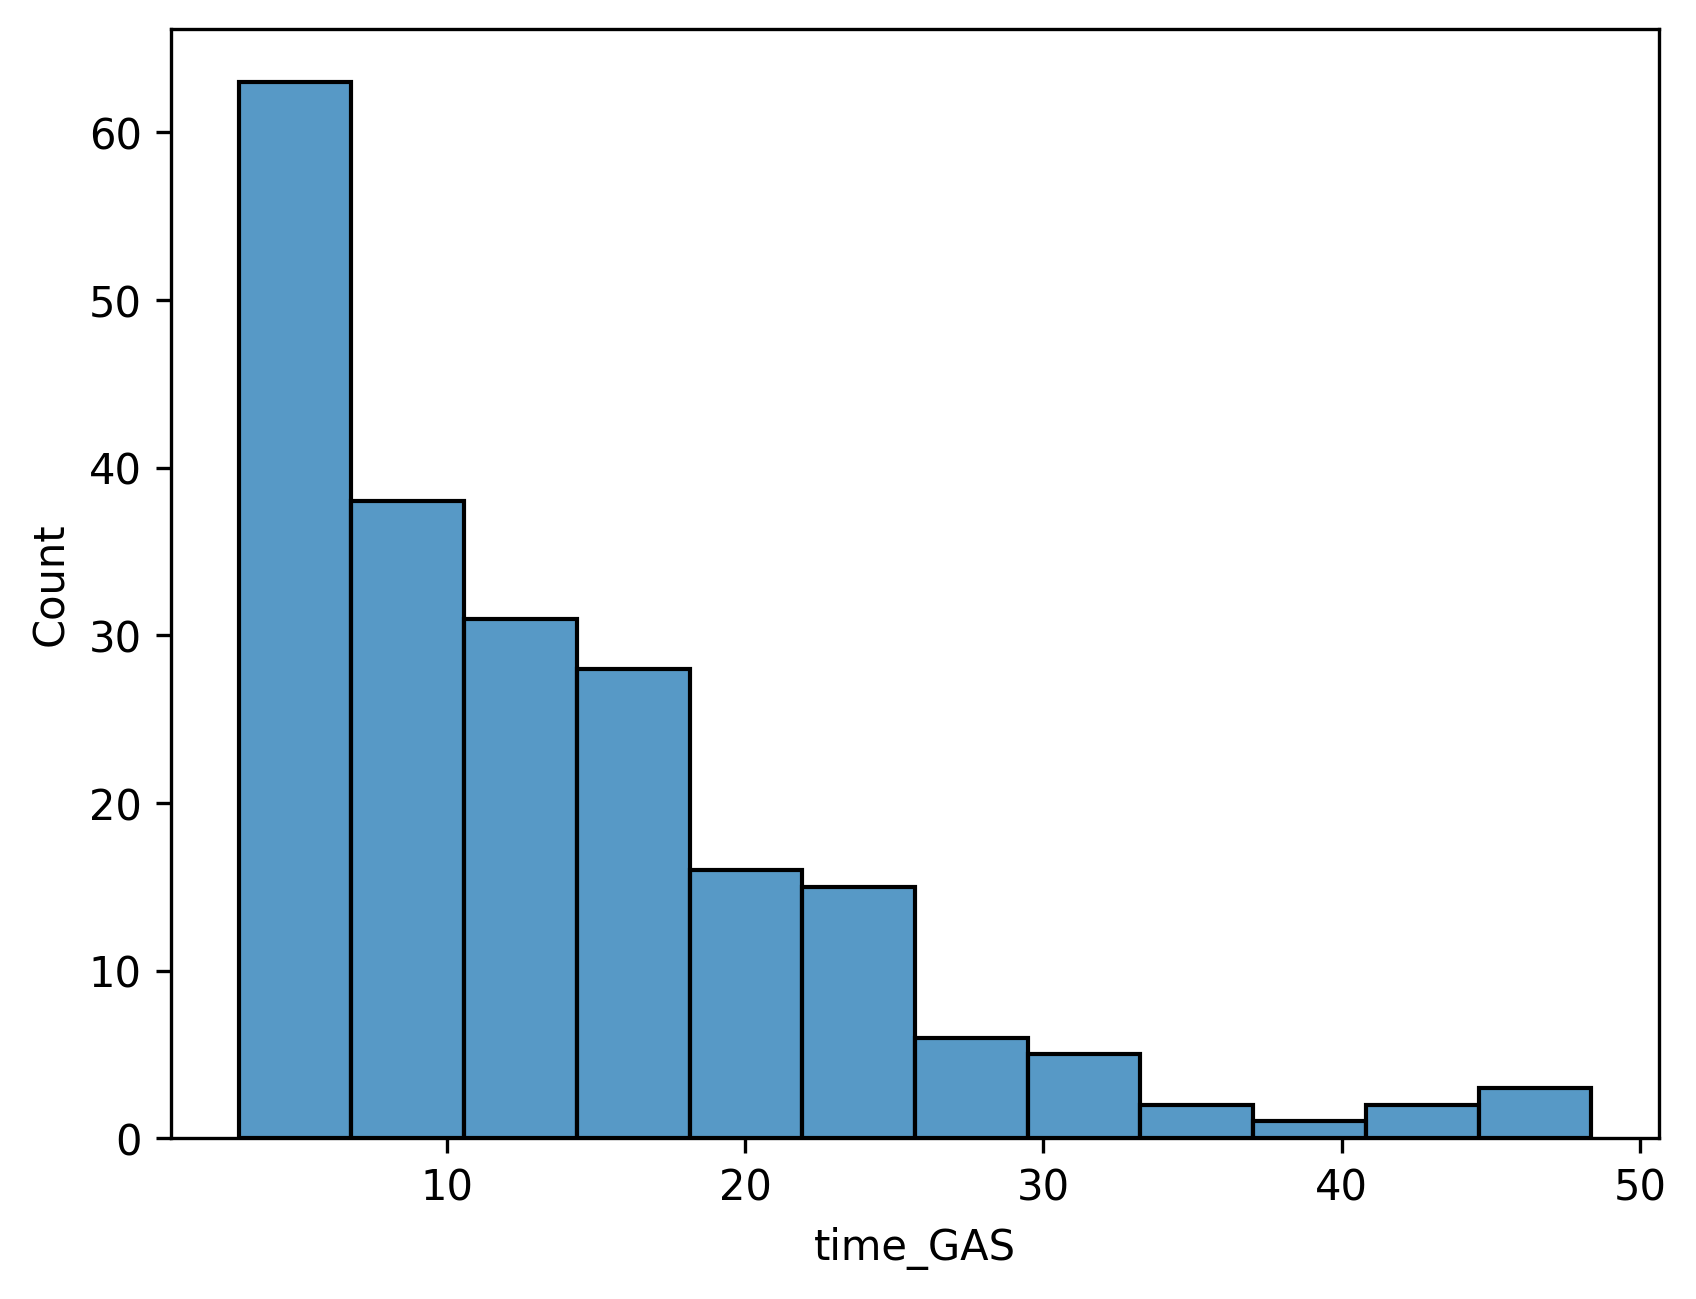

In [ ]:
sns.histplot(Target_Data['time_GAS'])

In [ ]:
Target_Data.query('time_GAS <= 3.0')

,SubjectID,time_GAS,status_GAS


In [ ]:
print(len(Target_Data.query('time_GAS <= 3.0')['SubjectID'].tolist()), 'patients has time_GAS 3 month or less')

0 patients has time_GAS 3 month or less


In [ ]:
Target_Data_final = Target_Data.query('time_GAS > 3.0')

# minus 3months for target data value
Target_Data_final['time_GAS'] = Target_Data_final['time_GAS'] -3.0

GAS = Target_Data_final
GAS

,SubjectID,time_GAS,status_GAS
0,1005.0,27.378082,0
1,1019.0,10.117808,1
2,1021.0,44.769863,1
3,1030.0,29.942466,0
4,1031.0,20.013699,0
...,...,...,...
205,1642.0,1.832877,0
206,1650.0,0.484932,0
207,1654.0,0.221918,0
208,11871.0,9.361644,0


In [ ]:
print(len(Target_Data['SubjectID'])-len(Target_Data_final['SubjectID']), 'patients were excluded because of early occurrence or censoring')
print(len(Target_Data.query('(time_GAS <= 3.0) and (status_GAS == 0)')), 'out of 7 are early censored (follow up being < 3mo)')
print(len(Target_Data.query('(time_GAS <= 3.0) and (status_GAS == 1)')), 'out of 7 are early occured (occurred before 3mo)')

0 patients were excluded because of early occurrence or censoring
0 out of 7 are early censored (follow up being < 3mo)
0 out of 7 are early occured (occurred before 3mo)


In [ ]:
# Note that 'time_GAS' is month scaled

In [ ]:
LOA = X_with_nans_snuh[['SubjectID','time_LOA', 'status_LOA']]
LOA

,SubjectID,time_LOA,status_LOA
0,1005.0,27.378082,1
1,1019.0,17.515068,0
2,1021.0,44.769863,0
3,1030.0,21.394521,1
4,1031.0,20.013699,0
...,...,...,...
205,1642.0,1.832877,0
206,1650.0,0.484932,0
207,1654.0,0.221918,0
208,11871.0,9.361644,0


In [ ]:
# Check the proportion of censored data
print("There are ", len(LOA[LOA['status_LOA']==0]), "censored data in",len(LOA), " Loss of Autonomy")
print("There are ", len(GAS[GAS['status_GAS']==0]), "censored data in",len(GAS), " gastrostomy")

There are  180 censored data in 210  Loss of Autonomy
There are  169 censored data in 210  gastrostomy


### (ii) KM estimation on each target





In [ ]:
merged_target = pd.merge(LOA, GAS, on='SubjectID', how='inner')
merged_target

,SubjectID,time_LOA,status_LOA,time_GAS,status_GAS
0,1005.0,27.378082,1,27.378082,0
1,1019.0,17.515068,0,10.117808,1
2,1021.0,44.769863,0,44.769863,1
3,1030.0,21.394521,1,29.942466,0
4,1031.0,20.013699,0,20.013699,0
...,...,...,...,...,...
205,1642.0,1.832877,0,1.832877,0
206,1650.0,0.484932,0,0.484932,0
207,1654.0,0.221918,0,0.221918,0
208,11871.0,9.361644,0,9.361644,0


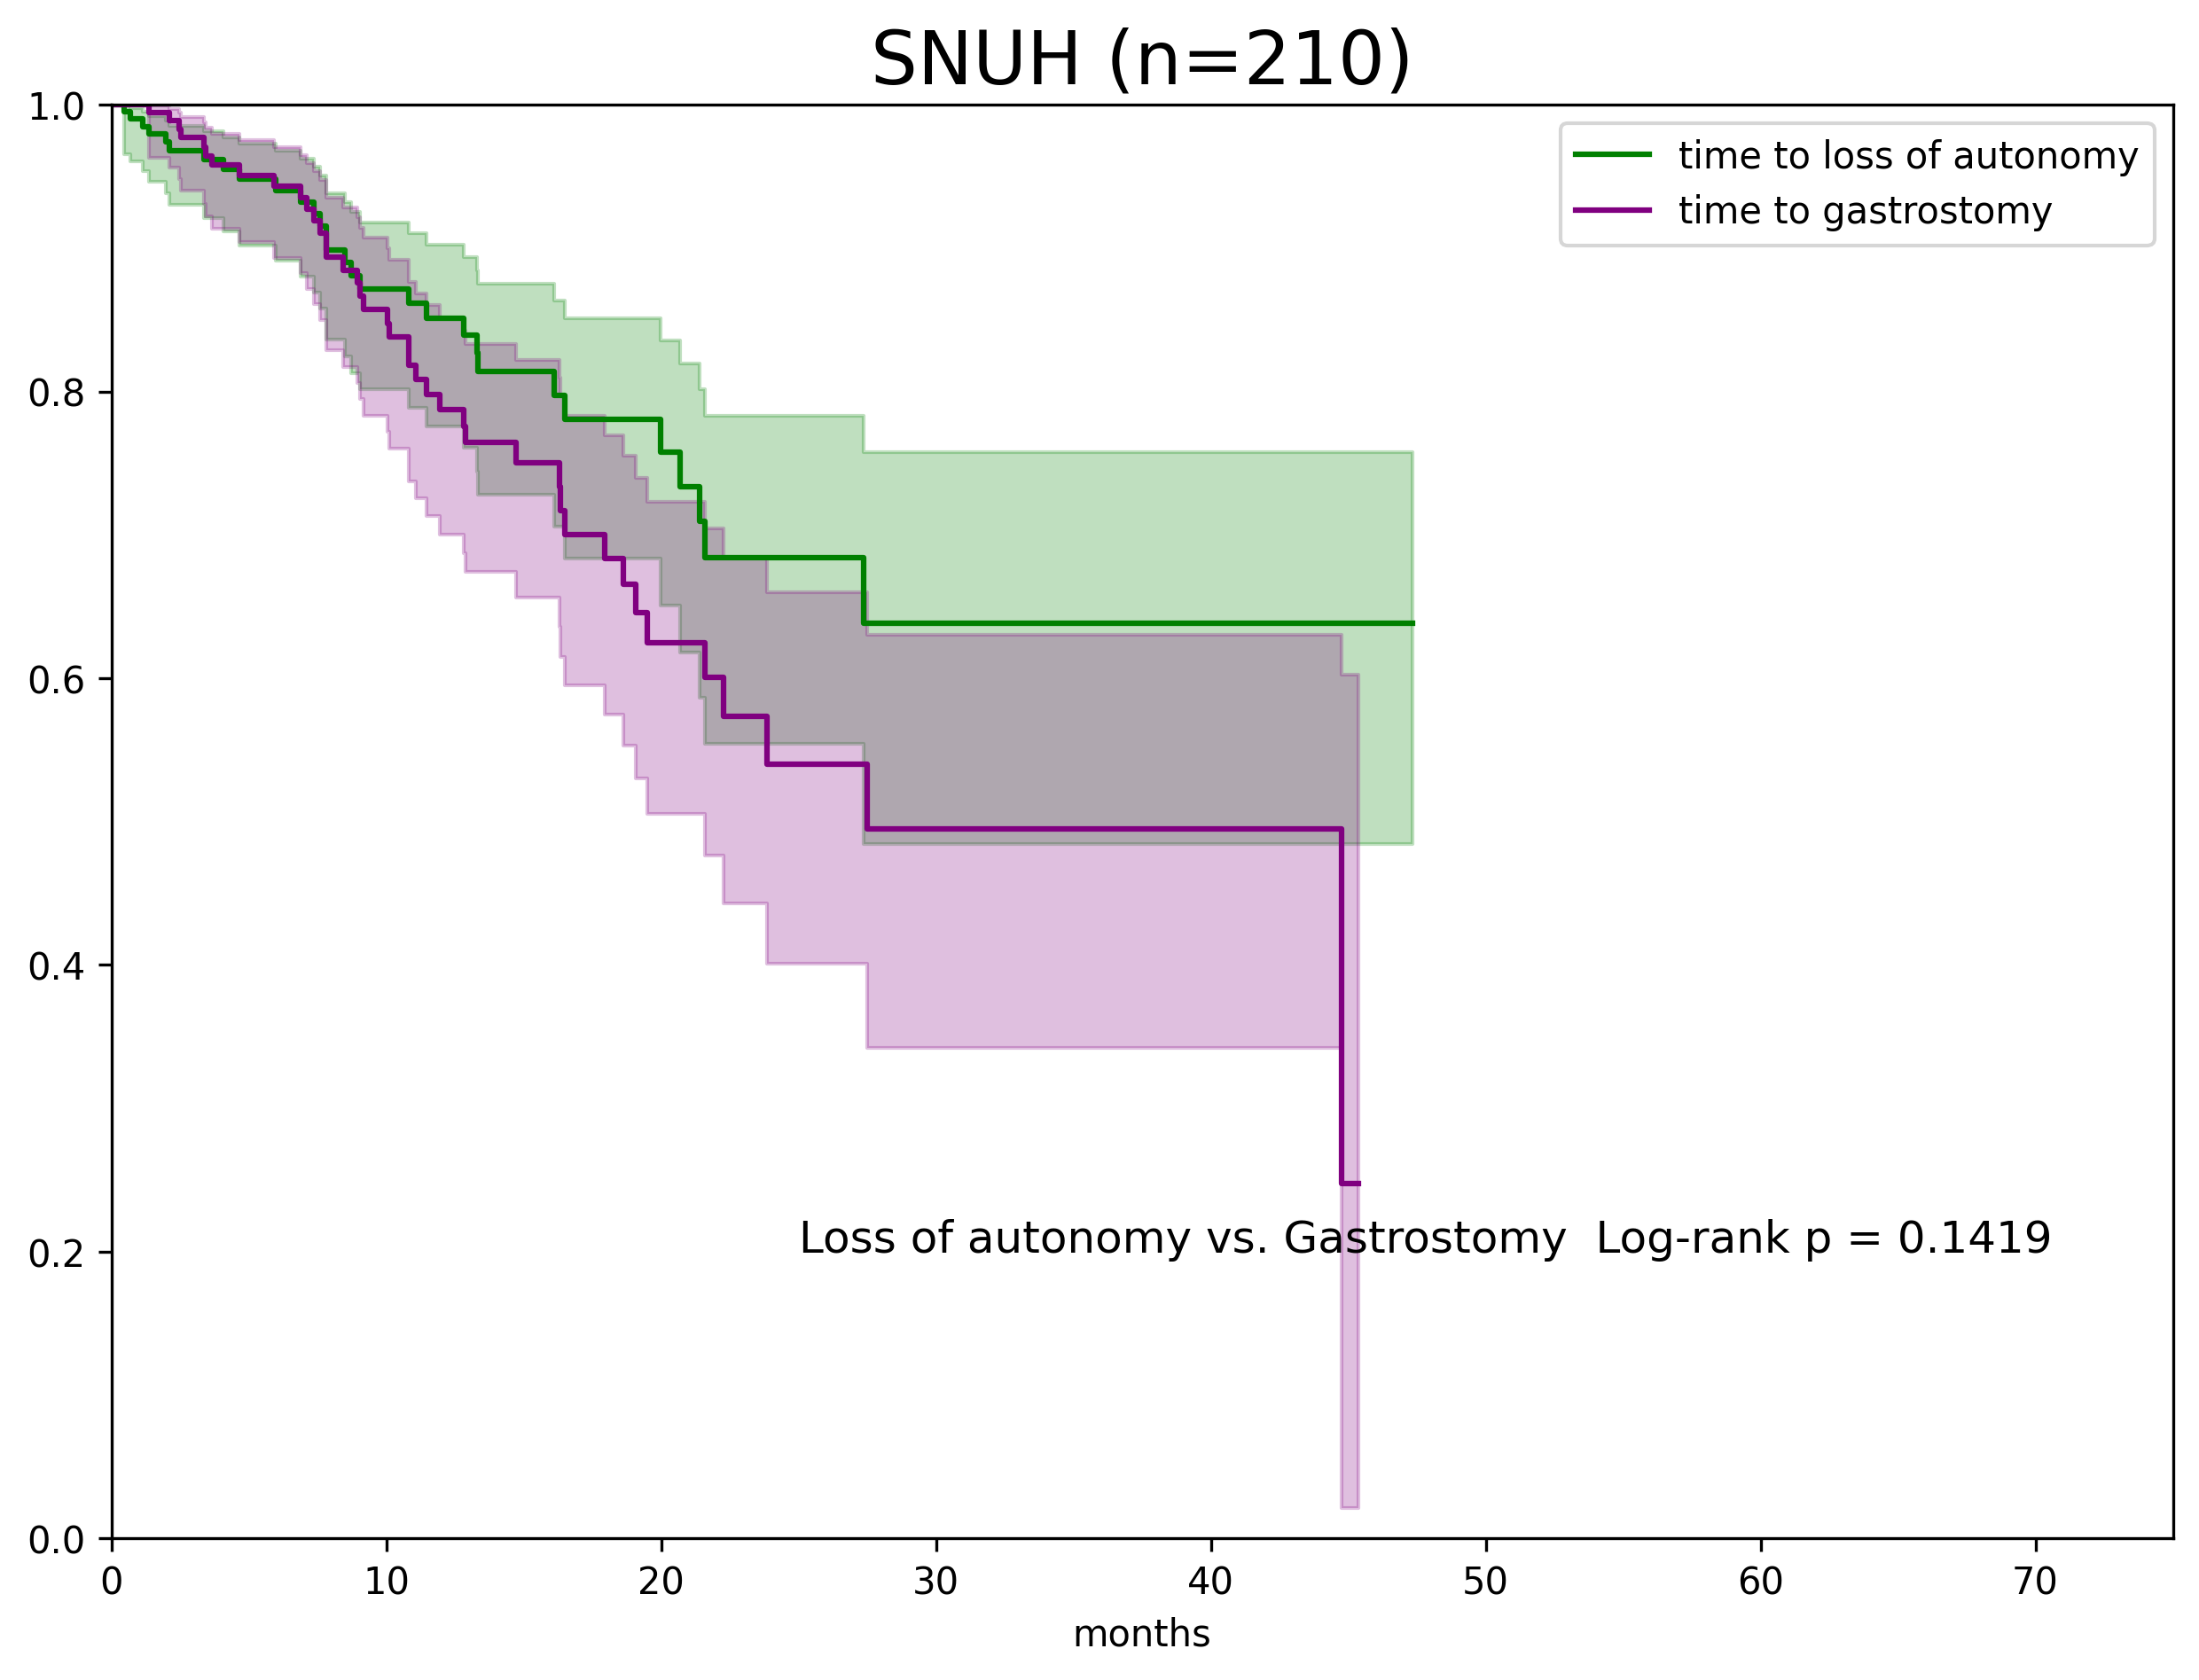

In [ ]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 7))

# Calculate log-rank test p-value
log_rank_result = logrank_test(merged_target["time_LOA"], merged_target["time_GAS"], merged_target["status_LOA"], merged_target["status_GAS"])

LOA_plot = kmf.fit(merged_target["time_LOA"], merged_target["status_LOA"], label='time to loss of autonomy')
ax_kmf = LOA_plot.plot(color='green')
plt.xlim([0,75])
plt.ylim([0,1])

GAS_plot = kmf.fit(merged_target['time_GAS'], merged_target['status_GAS'], label='time to gastrostomy')
ax_kmf2 = GAS_plot.plot(color='purple')
plt.xlim([0,75])
plt.ylim([0,1])

plt.annotate(f'Loss of autonomy vs. Gastrostomy  Log-rank p = {log_rank_result.p_value:.4f}', xy=(25, 0.2), color='k', fontsize=12)
plt.xlabel('months')
plt.title('SNUH (n=210)', fontsize=20)
plt.show()

### (iii) Scatterplot of time_LOA & time_GAS

In [ ]:
print("There are ", len(merged_target.query('status_LOA ==1 and status_GAS ==1')), "occurred data in",len(merged_target), " merged target")

There are  21 occurred data in 210  merged target


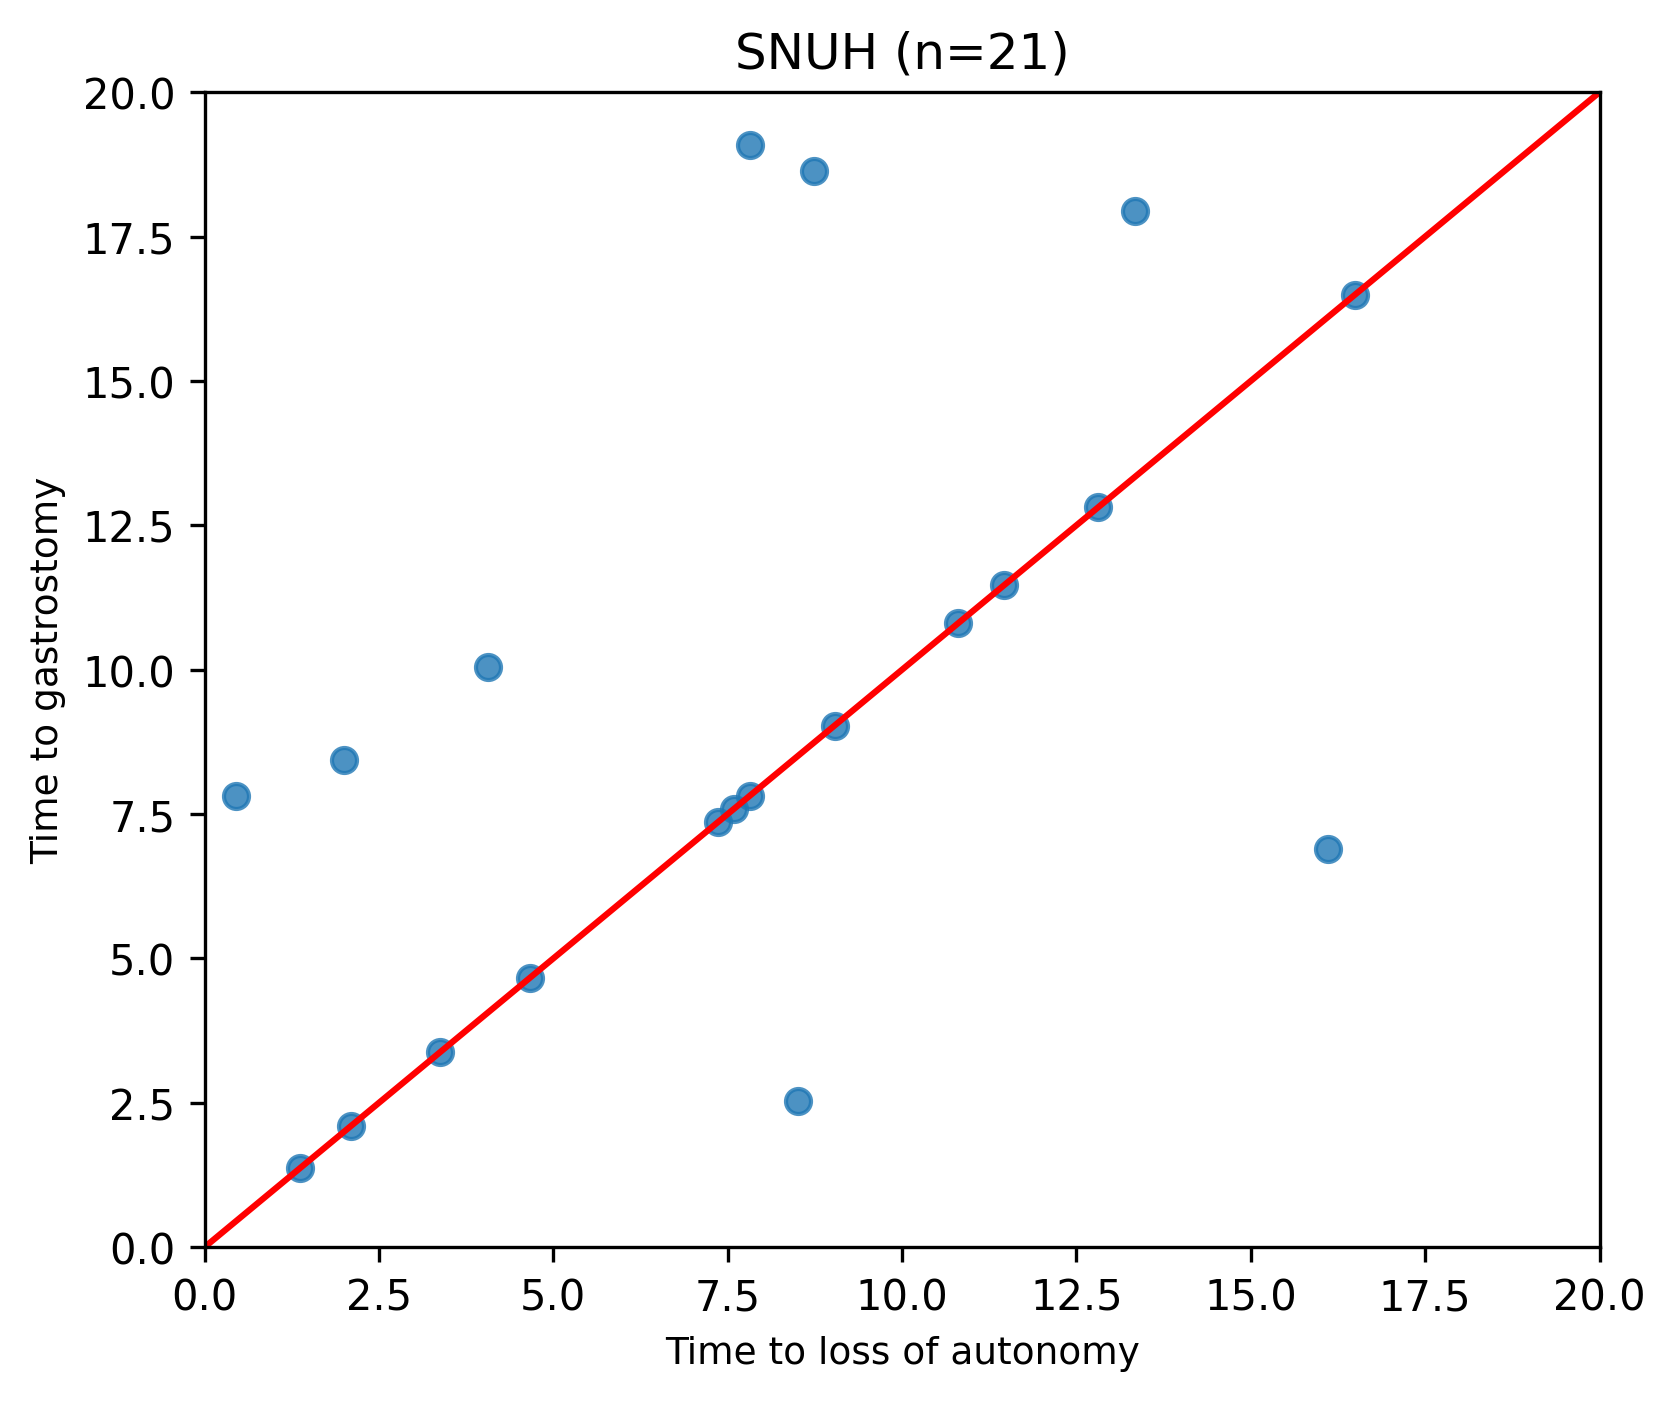

In [ ]:
scat_df = merged_target.query('status_LOA ==1 and status_GAS ==1')
fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(x=scat_df['time_LOA'], y=scat_df['time_GAS'], fit_reg=False)
plt.xlabel('Time to loss of autonomy', fontsize=9)
plt.ylabel('Time to gastrostomy', fontsize=9)
plt.title('SNUH (n=21)')
ax.plot([0,1],[0,1], transform=ax.transAxes, color='red') # y=x line
plt.xlim([0,20])
plt.ylim([0,20])
plt.show() # shows enough match